# 0.0. Imports

In [1]:
import numpy   as np
import pandas  as pd
import random
import seaborn as sns 
import warnings

from matplotlib import pyplot as plt

from scipy      import stats           as ss
from sklearn    import model_selection as ms
from sklearn    import preprocessing   as pp
from sklearn    import metrics         as m
from scikitplot import metrics         as mt

from sklearn.ensemble      import RandomForestRegressor

from imblearn import under_sampling as us
from imblearn import over_sampling  as osamp
from imblearn import combine        as comb

from category_encoders import TargetEncoder

# from pandas_profiling import ProfileReport

from keras import models as ml
from keras import layers as l

warnings.filterwarnings('ignore')

## 0.1. Auxiliar Functions

In [2]:
def cross_validation(num_fold, x_train, y_train, model, response_encoder, balance_model=False, verbose=False):
    # generate k-fold
    num_folds = 5
    kfold = ms.StratifiedKFold( n_splits=num_folds, shuffle=True, random_state=32 )

    # create empty metrics list
    acc_list = []
    balanced_acc_list = []
    kappa_list = []

    # sequence of loop for verbose
    i = 1
    
    # interation to measure performance
    for train_index, val_index in kfold.split( x_train, response_encoder.inverse_transform(y_train) ):
        if verbose:
            print(f'Fold Number:{i}/{num_folds}')

        # split data into training and test set
        x_train_cv = x_train.iloc[train_index]
        y_train_cv = y_train.iloc[train_index]

        x_validation_cv = x_train.iloc[val_index]
        y_validation_cv = y_train.iloc[val_index]
        
        # balance of dataset
        if balance_model != False:
            # resample the dataset
            x_train_cv, y_train_cv = balance_model.fit_resample(x_train_cv, response_encoder.inverse_transform(y_train_cv))
            
            # convert back to encoding representation
            y_train_cv = pd.DataFrame(response_encoder.transform(y_train_cv.reshape(-1,1)).toarray(), 
                                      columns=response_encoder.categories_[0], 
                                      index=x_train_cv.index)

        # train model
        model.fit(x_train_cv, y_train_cv, epochs=100, batch_size=32, verbose=0)

        # prediction
        pred_cv = model.predict(x_validation_cv)

        # invert prediction
        yhat_cv = response_encoder.inverse_transform(pred_cv)

        # invert validation response
        y_test_cv = response_encoder.inverse_transform(y_validation_cv)

        # performance metrics
        # Accuracy
        acc_model = m.accuracy_score( y_test_cv, yhat_cv )
        acc_list.append(acc_model)
        
        # Balanced Accuracy
        balanced_acc_model = m.balanced_accuracy_score(y_test_cv, yhat_cv)
        balanced_acc_list.append(balanced_acc_model)

        # Kappa Metrics
        kappa_model = m.cohen_kappa_score(y_test_cv, yhat_cv)
        kappa_list.append(kappa_model)

        i += 1

    return acc_list, balanced_acc_list, kappa_list


def cramer_v(x, y):
    
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    rcorr = r - ((r-1)**2)/(n-1)
    
    kcorr = k - ((k-1)**2)/(n-1)
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1, rcorr-1)))

## 0.2. Load Data

In [3]:
# load training set of user
data_users = pd.read_csv('../Datasets/train_users_2.csv', low_memory=False)

# load web sessions log for users
data_sessions = pd.read_csv('../Datasets/sessions.csv', low_memory=False)

# 1.0. Data Description

In [4]:
df01_users = data_users.copy()

df01_sessions = data_sessions.copy()

## 1.1. Data Types

In [5]:
df01_users.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [6]:
df01_sessions.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

## 1.2. Data Dimensions

### 1.2.1. Data Users Dimensions 

In [7]:
print( f'Number of rows of users dataset: {df01_users.shape[0]}')
print( f'Number of columnss of users dataset: {df01_users.shape[1]}')

Number of rows of users dataset: 213451
Number of columnss of users dataset: 16


### 1.2.2. Data Sessions Dimensions

This dataset will not be used in this first cycle due to the granularity being action and we want to be user_id for now.

In [8]:
print( f'Number of rows of sessions dataset: {df01_sessions.shape[0]}')
print( f'Number of columnss of session dataset: {df01_sessions.shape[1]}')

Number of rows of sessions dataset: 10567737
Number of columnss of session dataset: 6


## 1.3. Check NA

### 1.3.1. Check NA - Data Users

In [9]:
df01_users.isna().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

In [10]:
df01_users.isna().sum()/df01_users.shape[0]

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

### 1.3.2. Check NA - Data Sessions

In [11]:
df01_sessions.isna().sum()

user_id            34496
action             79626
action_type      1126204
action_detail    1126204
device_type            0
secs_elapsed      136031
dtype: int64

In [12]:
df01_sessions.isna().sum()/df01_sessions.shape[0]

user_id          0.003264
action           0.007535
action_type      0.106570
action_detail    0.106570
device_type      0.000000
secs_elapsed     0.012872
dtype: float64

## 1.4. Fillout NA

### 1.4.1. Fillout NA - Data Users

- **date_first_booking:** the maximum date of the dataset is chosen due to future features considered the space between dates.

- **age:** variable age has a normal distribution, so replacing it with with a mean value will not bias the dataset.

- **first_affiliate_tracked:** due to the high probability of bias the dataset with categorical data substitution and the low amount of NA datas in this variable, the NA lines will be dropped.

In [13]:
# date_first_booking
max_date_first_booking = pd.to_datetime(df01_users['date_first_booking']).max().strftime('%Y-%m-%d')
df01_users['date_first_booking'] = df01_users['date_first_booking'].fillna(max_date_first_booking)

# age
avg_age = int(df01_users['age'].mean())
df01_users['age'] = df01_users['age'].fillna(avg_age)

# first_affiliate_tracked
df01_users = df01_users[~df01_users['first_affiliate_tracked'].isna()]

In [14]:
df01_users.isna().sum()/df01_users.shape[0]

id                         0.0
date_account_created       0.0
timestamp_first_active     0.0
date_first_booking         0.0
gender                     0.0
age                        0.0
signup_method              0.0
signup_flow                0.0
language                   0.0
affiliate_channel          0.0
affiliate_provider         0.0
first_affiliate_tracked    0.0
signup_app                 0.0
first_device_type          0.0
first_browser              0.0
country_destination        0.0
dtype: float64

### 1.4.2. Fillout NA - Data Sessions

Due to a massise amount of data, all NA lines will be dropped.

In [15]:
# user_id  - 0.003264
df01_sessions = df01_sessions[~df01_sessions['user_id'].isna()]

# action - 0.007535
df01_sessions = df01_sessions[~df01_sessions['action'].isna()]

# action_type - 0.106570
df01_sessions = df01_sessions[~df01_sessions['action_type'].isna()]

# action_detail - 0.106570
df01_sessions = df01_sessions[~df01_sessions['action_detail'].isna()]

# secs_elapsed - 0.012872
df01_sessions = df01_sessions[~df01_sessions['secs_elapsed'].isna()]

In [16]:
df01_sessions.isna().sum()/df01_sessions.shape[0]

user_id          0.0
action           0.0
action_type      0.0
action_detail    0.0
device_type      0.0
secs_elapsed     0.0
dtype: float64

## 1.5. Change Data Type

In [17]:
df01_users.sample(1)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
171635,e5yctyx5mn,2014-04-04,20140404124156,2015-06-29,-unknown-,49.0,basic,24,en,other,meetup,tracked-other,Moweb,Android Phone,Android Browser,NDF


In [18]:
# change date type
df01_users['date_account_created'] = pd.to_datetime(df01_users['date_account_created'])
df01_users['date_first_booking'] = pd.to_datetime(df01_users['date_first_booking'])

# change datetime type
df01_users['timestamp_first_active'] = pd.to_datetime(df01_users['timestamp_first_active'], format='%Y%m%d%H%M%S')

# change age to int
df01_users['age'] = df01_users['age'].astype(np.int64)

In [19]:
df01_users.sample(1)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
187079,c1jj9b7udl,2014-05-10,2014-05-10 06:55:20,2015-06-29,-unknown-,46,basic,0,en,sem-brand,google,omg,Web,Windows Desktop,Firefox,NDF


In [20]:
df01_users.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

## 1.6. Check Balanced Data

Data with an unbalance of 57% for the NDF class and 30% for the US class.

In [21]:
df01_users['country_destination'].value_counts(normalize=True)

NDF      0.579673
US       0.294461
other    0.048128
FR       0.023623
IT       0.013458
GB       0.011066
ES       0.010671
CA       0.006707
DE       0.005020
NL       0.003621
AU       0.002541
PT       0.001032
Name: country_destination, dtype: float64

## 1.7. Descriptive Analysis

In [22]:
# split data users in types dataframes
num_attributes_users = df01_users.select_dtypes(include=['int64', 'float64'])
cat_attributes_users = df01_users.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
time_attributes_users = df01_users.select_dtypes(include=['datetime64[ns]'])

# split data sessions in types dataframes
num_attributes_sessions = df01_sessions.select_dtypes(include=['int64', 'float64'])
cat_attributes_sessions = df01_sessions.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
time_attributes_sessions = df01_sessions.select_dtypes(include=['datetime64[ns]'])

### 1.7.1. Numerical - Data Users

In [23]:
# tendency central - mean and median
mean_users = pd.DataFrame(num_attributes_users.apply(lambda x: np.mean(x)))
median_users = pd.DataFrame(num_attributes_users.apply(lambda x: np.median(x)))

# dispersions - max, min, range, std, skew and kurtosis
max_users = pd.DataFrame(num_attributes_users.apply(lambda x: x.max()))
min_users = pd.DataFrame(num_attributes_users.apply(lambda x: x.min()))
range_users = pd.DataFrame(num_attributes_users.apply(lambda x: x.max() - x.min()))
std_users = pd.DataFrame(num_attributes_users.apply(lambda x: np.std(x)))
skew_users = pd.DataFrame(num_attributes_users.apply(lambda x: x.skew()))
kurtosis_users = pd.DataFrame(num_attributes_users.apply(lambda x: x.kurtosis()))

# join tendency central and dispersion dataframe
num_stats_users = pd.concat([max_users, min_users, range_users, mean_users, 
                             median_users, std_users, skew_users, kurtosis_users], axis=1).reset_index()
num_stats_users.columns = ['attributes', 'max', 'min', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

num_stats_users

,attributes,max,min,range,mean,median,std,skew,kurtosis
0,age,2014,1,2013,49.183142,49.0,118.421689,16.333820,267.655434
1,signup_flow,25,0,25,3.151490,0.0,7.543915,2.287158,3.567794


### 1.7.2. Numerical - Data Sessions

In [24]:
# tendency central - mean and median
mean_sessions = pd.DataFrame(num_attributes_sessions.apply(lambda x: np.mean(x)))
median_sessions = pd.DataFrame(num_attributes_sessions.apply(lambda x: np.median(x)))

# dispersions - max, min, range, std, skew and kurtosis
max_sessions = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.max()))
min_sessions = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.min()))
range_sessions = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.max() - x.min()))
std_sessions = pd.DataFrame(num_attributes_sessions.apply(lambda x: np.std(x)))
skew_sessions = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.skew()))
kurtosis_sessions = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.kurtosis()))

# join tendency central and dispersion dataframe
num_stats_sessions = pd.concat([max_sessions, min_sessions, range_sessions, mean_sessions, 
                             median_sessions, std_sessions, skew_sessions, kurtosis_sessions], axis=1).reset_index()
num_stats_sessions.columns = ['attributes', 'max', 'min', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

num_stats_sessions

,attributes,max,min,range,mean,median,std,skew,kurtosis
0,secs_elapsed,1799977.0,0.0,1799977.0,19961.8251,1369.0,88849.388449,11.137761,154.84312


### 1.7.3. Categorical - Data Users

In [25]:
cat_attributes_users.drop('id', axis=1).describe()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,207386,207386,207386,207386,207386,207386,207386,207386,207386,207386
unique,4,3,25,8,18,7,4,9,52,12
top,-unknown-,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,91783,148297,200415,134179,133935,109232,178334,89600,63845,120216


#### 1.7.3.1. Correlation Matrix

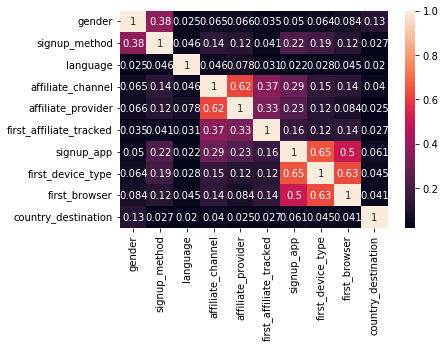

In [26]:
cat_attributes_users_columns = cat_attributes_users.drop('id', axis=1).columns.tolist()

corr_dict = {}

for main_column in cat_attributes_users_columns:
    corr_list = []
    
    for secondary_column in cat_attributes_users_columns:
        # cramer v
        cat_corr = cramer_v( cat_attributes_users[main_column], cat_attributes_users[secondary_column] )
        
        # add to list
        corr_list.append(cat_corr)
    
    # add to dict each attribute correlation 
    corr_dict[main_column] = corr_list

df_corr_users = pd.DataFrame(corr_dict)
df_corr_users = df_corr_users.set_index(df_corr_users.columns)
sns.heatmap(df_corr_users, annot=True);

### 1.7.4. Categorical - Data Sessions

In [27]:
cat_attributes_sessions.drop('user_id', axis=1).describe()

,action,action_type,action_detail,device_type
count,9213930,9213930,9213930,9213930
unique,347,10,155,14
top,show,view,view_search_results,Mac Desktop
freq,2178382,3545621,1770931,3019523


#### 1.7.4.1. Correlation Matrix

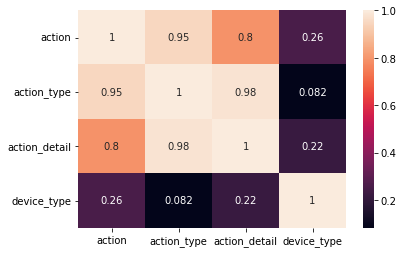

In [28]:
cat_attributes_sessions_columns = cat_attributes_sessions.drop('user_id', axis=1).columns.tolist()

corr_dict = {}

for main_column in cat_attributes_sessions_columns:
    corr_list = []
    
    for secondary_column in cat_attributes_sessions_columns:
        # cramer v
        cat_corr = cramer_v( cat_attributes_sessions[main_column], cat_attributes_sessions[secondary_column] )
        
        # add to list
        corr_list.append(cat_corr)
    
    # add to dict each attribute correlation 
    corr_dict[main_column] = corr_list

df_corr_sessions = pd.DataFrame(corr_dict)
df_corr_sessions = df_corr_sessions.set_index(df_corr_sessions.columns)
sns.heatmap(df_corr_sessions, annot=True);

# 2.0. Feature Engineering

In [29]:
df02_users = df01_users.copy()

## 2.1. Create Gap Between Dates Features

In [30]:
# date of first active
df02_users['date_first_active'] = pd.to_datetime(df02_users['timestamp_first_active'].dt.strftime("%Y-%m-%d"))

# difference in days between date_account_created and date_first_active
df02_users['diff_account_created_first_active'] = (df02_users['date_account_created'] - df02_users['date_first_active']).apply(lambda x: x.days)

# difference in days between date_account_created and date_first_booking
df02_users['diff_first_booking_account_created'] = (df02_users['date_first_booking'] - df02_users['date_account_created']).apply(lambda x: x.days)

# difference in days between date_first_active and date_first_booking
df02_users['diff_first_active_first_booking'] = (df02_users['date_first_booking'] - df02_users['date_first_active']).apply(lambda x: x.days)

## 2.2. Create Date Features

### 2.2.1. Account Created

In [31]:
# year
df02_users['year_account_created'] = df02_users['date_account_created'].dt.year

# month
df02_users['month_account_created'] = df02_users['date_account_created'].dt.month

# day
df02_users['day_account_created'] = df02_users['date_account_created'].dt.day

# day of week
df02_users['dayofweek_account_created'] = df02_users['date_account_created'].dt.dayofweek

# week of year
df02_users['weekofyear_account_created'] = df02_users['date_account_created'].dt.weekofyear

### 2.2.2. First Active

In [32]:
# year
df02_users['year_first_active'] = df02_users['date_first_active'].dt.year

# month
df02_users['month_first_active'] = df02_users['date_first_active'].dt.month

# day
df02_users['day_first_active'] = df02_users['date_first_active'].dt.day

# day of week
df02_users['dayofweek_first_active'] = df02_users['date_first_active'].dt.dayofweek

# week of year
df02_users['weekofyear_first_active'] = df02_users['date_first_active'].dt.weekofyear

### 2.2.3. First Booking

In [33]:
# year
df02_users['year_first_booking'] = df02_users['date_first_booking'].dt.year

# month
df02_users['month_first_booking'] = df02_users['date_first_booking'].dt.month

# day
df02_users['day_first_booking'] = df02_users['date_first_booking'].dt.day

# day of week
df02_users['dayofweek_first_booking'] = df02_users['date_first_booking'].dt.dayofweek

# week of year
df02_users['weekofyear_first_booking'] = df02_users['date_first_booking'].dt.weekofyear

# 3.0. Data Filtering

In [34]:
df03_users = df02_users.copy()

## 3.1. Filtering Rows

In [35]:
# age - greater than 15 and lower than 100 - There are few people over 100 years old ( Could be error from system or manual imput - Cleaning noise)
df03_users = df03_users[(df03_users['age'] > 15) & (df03_users['age'] < 100)]

# secs_elapsed - there is no possible 0 secs elapesed on website
#df03_sessions = df03_sessions[df03_sessions['secs_elapsed'] > 0]

## 3.2. Columns Selection

In [36]:
# columns id not carry any information
df03_users = df03_users.drop(['id'], axis=1)

# columns used to feature engineering
cols_date =['timestamp_first_active',
            'date_first_active',
            'date_account_created',
            'date_first_booking']

df03_users = df03_users.drop(columns=cols_date)

# 4.0. Data Exploratory Analysis

In [37]:
df04_users = df03_users.copy()

## 4.1. Univariate Analysis

In [39]:
# profile = ProfileReport(df04_users)

# profile.to_file(output_file='airbnb_booking_statistics.html')

## 4.2. Bivariate Analysis

### H1. Across all destinations, it takes users an average of 15 days to make their first Airbnb booking since their first activation.
**False:** Users take up to 3 days on median to register on the site all destinations.

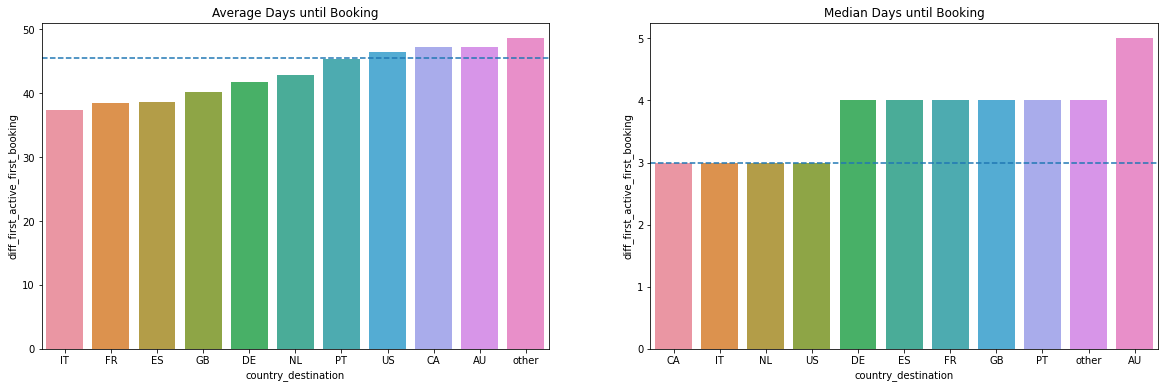

In [40]:
plt.subplots(figsize=(20,6))

# select data with destination
aux = df04_users[df04_users['country_destination'] != 'NDF']

# average number of days from the first active day on website to the first booking for each destination
plt.subplot(1, 2, 1)
aux1 = aux[['diff_first_active_first_booking', 'country_destination']].groupby('country_destination').mean().reset_index()
sns.barplot(x='country_destination', 
            y='diff_first_active_first_booking', 
            data=aux1.sort_values('diff_first_active_first_booking'))
plt.axhline(aux['diff_first_active_first_booking'].mean(), linestyle='--');
plt.title('Average Days until Booking');

# median number of days from the first active day on website to the first booking for each destination
plt.subplot(1, 2, 2)
aux2 = aux[['diff_first_active_first_booking', 'country_destination']].groupby('country_destination').median().reset_index()
sns.barplot(x='country_destination', 
            y='diff_first_active_first_booking',
            data=aux2.sort_values('diff_first_active_first_booking'))
plt.axhline(aux['diff_first_active_first_booking'].median(), linestyle='--');
plt.title('Median Days until Booking');

### H2. In all destinations, it takes users an average of 3 days to register on the site.
**True:** Users register the same day they first visit, on average.

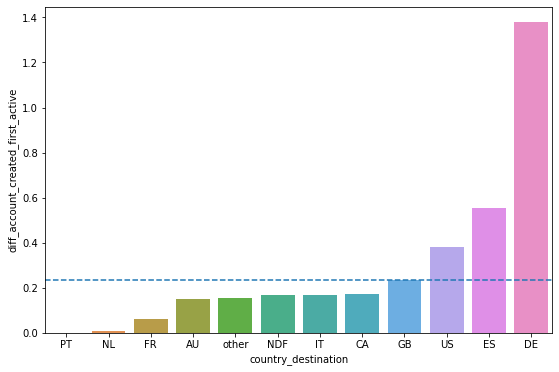

In [41]:
plt.subplots(figsize=(20,6))

# average number of days from the first active day on website to the first booking for each destination
plt.subplot(1, 2, 1)
aux1 = df04_users[['diff_account_created_first_active', 'country_destination']].groupby('country_destination').mean().reset_index()

sns.barplot(x='country_destination', 
            y='diff_account_created_first_active',
            data=aux1.sort_values('diff_account_created_first_active'))
plt.axhline(df04_users['diff_account_created_first_active'].mean(), linestyle='--');

### H3. The annual volume of bookings made during the summer increased by 20% or more for destinations within the USA.
**True:**  Bookings made during the summer for the USA grow by 80% a year on average.

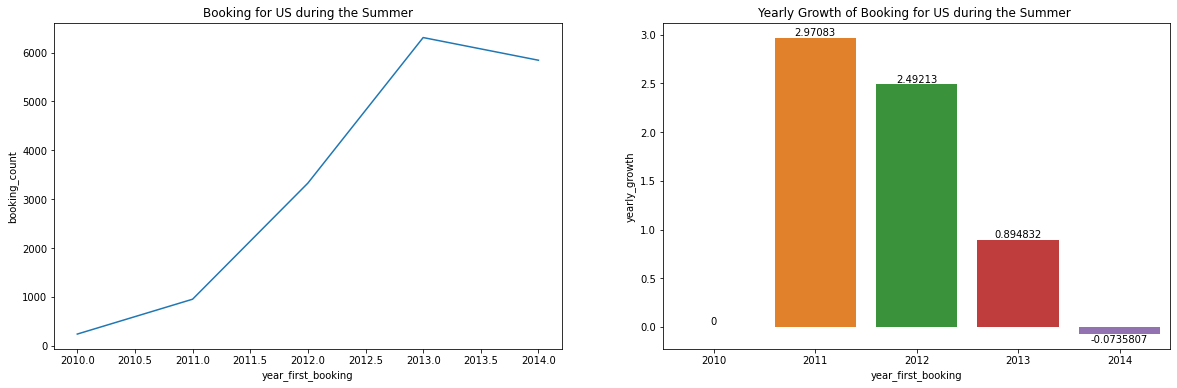

In [42]:
plt.figure(figsize=(20,6))

# number of booking for year, month of firsrt booking and destination by number of rows
aux1 = df04_users[['year_first_booking', 'month_first_booking', 'country_destination']].groupby(
    ['year_first_booking', 'month_first_booking', 'country_destination']
).size().reset_index().rename(columns={0: 'booking_count'})

# seasons for northern hemisphere
season_map = {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer',
              7: 'Summer', 8: 'Summer', 9: 'Autumn', 10: 'Autumn', 11: 'Autumn', 12: 'Winter'}

# seasons for each month of first booking
aux1['season'] = aux1['month_first_booking'].map(season_map)

# select data targeting the USA and the summer season 
aux2 = aux1[(aux1['country_destination'] == 'US') & (aux1['season'] == 'Summer') & (aux1['year_first_booking'] != 2015)]

# number of bookings for first booking year
aux3 = aux2[['year_first_booking', 'booking_count']].groupby('year_first_booking').sum().reset_index()

plt.subplot(1, 2, 1)
sns.lineplot(x='year_first_booking', y='booking_count', data=aux3)
plt.title('Booking for US during the Summer');

# porcentage of growth to each first booking year
aux3['yearly_growth'] = aux3['booking_count'].pct_change().fillna(0)

# yearly growth of first booking for US during the summer
plt.subplot(1, 2, 2)
ax = sns.barplot(x='year_first_booking', y='yearly_growth', data=aux3);
ax.bar_label(ax.containers[0]);
plt.title('Yearly Growth of Booking for US during the Summer ');



### H4. Female users make 10% more reservations for countries outside the USA.
**False:** Female users make more than 15% more reservations than male users.

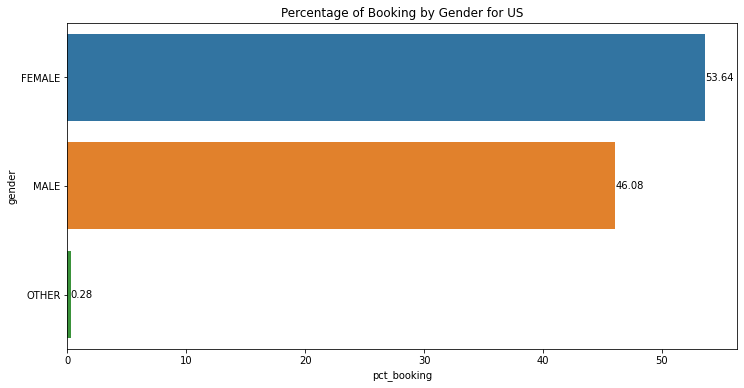

In [43]:
plt.figure(figsize=(12, 6))

# number of booking for gender and destination
aux1 = df04_users[['gender', 'country_destination']].groupby(
    ['gender', 'country_destination']
).size().reset_index().rename(columns={0: 'booking_count'})

# select data for US and droped unknow rows
aux2 = aux1[(aux1['country_destination'] == 'US') & (aux1['gender'] != '-unknown-')]

# percentage of bookings for each gender
aux2['pct_booking'] = round(100*(aux2['booking_count']/aux2['booking_count'].sum()), 2)

# percentage of bookings for each gender for US destination
ax = sns.barplot(x='pct_booking', y='gender', data=aux2);
ax.bar_label(ax.containers[0]);
plt.title('Percentage of Booking by Gender for US');

### H5. The Google Marketing channel accounts for more than 40% of bookings to countries outside the USA.
**True:** Considering only paid channel, Marketing Google represents 76% of bookings.

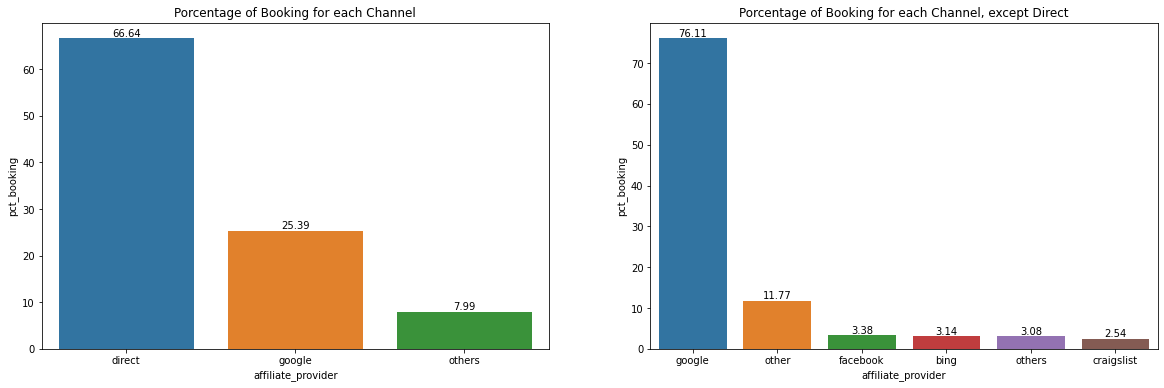

In [44]:
plt.figure(figsize=(20, 6))

# select data with destination and without US
aux = df04_users[(df04_users['country_destination'] != 'US') & (df04_users['country_destination'] != 'NDF')]

# number of booking por each affiliate
aux1 = aux[['affiliate_provider']].groupby('affiliate_provider').size().reset_index().rename(columns={0: 'booking_count'})

# porcentage of booking for each affiliate
aux1['pct_booking'] = round(100*aux1['booking_count']/aux1['booking_count'].sum(), 2)

# group values smaller than 10
aux2 = aux1['pct_booking'].groupby(
    np.where(aux1['pct_booking'] >=10, aux1['affiliate_provider'], 'others')
).sum().reset_index().rename(columns={'index': 'affiliate_provider'})

# percentage of booking for each channel
plt.subplot(1, 2, 1)
ax = sns.barplot(x='affiliate_provider', y='pct_booking', data=aux2)
ax.bar_label(ax.containers[0]);
plt.title('Porcentage of Booking for each Channel');

#not include organic channels
aux3 = aux[aux['affiliate_provider'] != 'direct']

# number of booking por each affiliate
aux4 = aux3[['affiliate_provider']].groupby('affiliate_provider').size().reset_index().rename(columns={0: 'booking_count'})

# porcentage of booking for each affiliate
aux4['pct_booking'] = round(100*aux4['booking_count']/aux4['booking_count'].sum(), 2)

# group values smaller than 10
aux5 = aux4['pct_booking'].groupby(
    np.where(aux4['pct_booking'] > 1, aux4['affiliate_provider'], 'others')
).sum().reset_index().rename(columns={'index': 'affiliate_provider'}).sort_values('pct_booking', ascending=False)

# percentage of booking for each channel
plt.subplot(1, 2, 2)
ax = sns.barplot(x='affiliate_provider', y='pct_booking', data=aux5)
ax.bar_label(ax.containers[0]);
plt.title('Porcentage of Booking for each Channel, except Direct');

### H6. The USA destination represents more than 20% in all channels.
**True:** USA represents 69% of bookings on average in all channels.

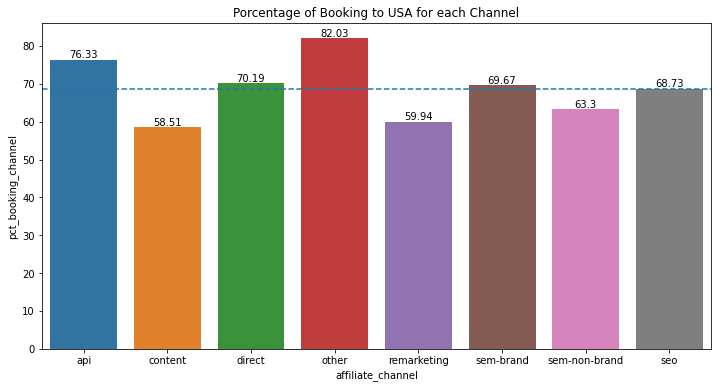

In [45]:
plt.figure(figsize=(12, 6))

# select data with distination
aux = df04_users[df04_users['country_destination'] != 'NDF']

# number of booking for each destination and affiliate channel
aux1 = aux[['country_destination', 'affiliate_channel']].groupby(
    ['country_destination', 'affiliate_channel']
).size().reset_index().rename(columns={0: 'booking_count'})

# create column for porcentage of booking for each channel
aux1['pct_booking_channel'] = np.nan

# porcentage individual for each affiliate channel
for channel in aux1['affiliate_channel'].unique().tolist():
    ref_channel = aux1['affiliate_channel'] == channel
    aux1.loc[ref_channel, 'pct_booking_channel'] = np.round(
        100 * aux1.loc[ref_channel, 'booking_count'] / aux1.loc[ref_channel, 'booking_count'].sum(), 2
)

# select destination for US
aux2 = aux1[aux1['country_destination'] == 'US']

# percentage of bookings for channels for US destination 
ax = sns.barplot(x='affiliate_channel', y='pct_booking_channel', data=aux2)
ax.bar_label(ax.containers[0]);
plt.axhline(aux2['pct_booking_channel'].mean(), linestyle='--')
plt.title('Porcentage of Booking to USA for each Channel');

### H7. The average age of people is 35 in all destinations.
**False:** Average age for all destinations is 40 years old.

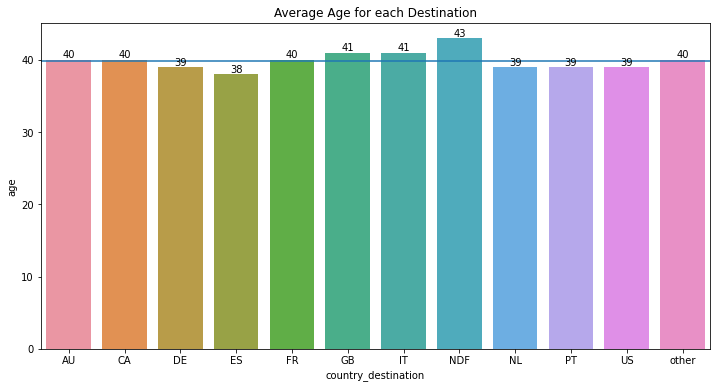

In [46]:
plt.figure(figsize=(12, 6))

# grouped country destination
aux1 = df04_users[['age', 'country_destination']].groupby('country_destination').mean().astype(int).reset_index()

# average age for each destination
ax = sns.barplot(x='country_destination', y='age', data=aux1);
ax.bar_label(ax.containers[0]);
plt.axhline(aux1['age'].mean());
plt.title('Average Age for each Destination');

### H8. The percentage of users who use the English language site to book accommodations at any destination is over 90%.
**True:** English is dominant among users, accounting for 97%.  

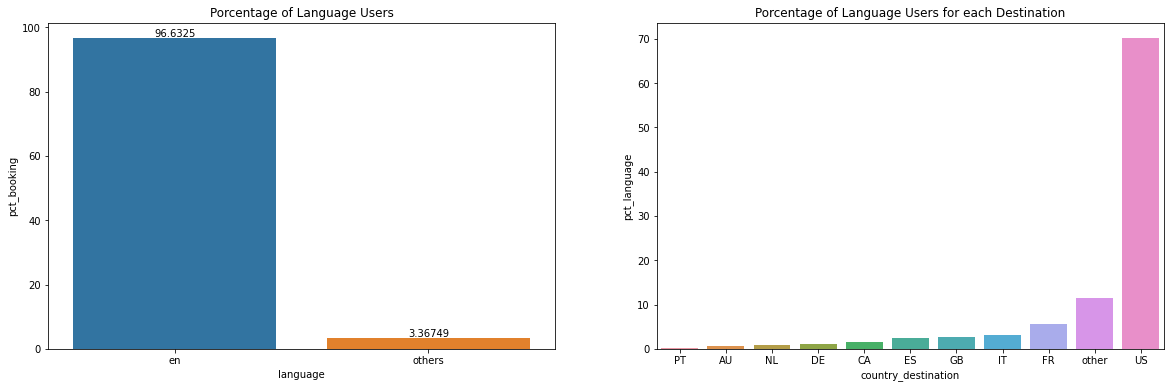

In [47]:
plt.figure(figsize=(20,6))

# number of booking for each language
aux1 = df04_users[['language']].groupby('language').size().reset_index().rename(columns={0: 'booking_count'})

# porcentage of bookings for each language
aux1['pct_booking'] = 100*aux1['booking_count']/aux1['booking_count'].sum()

# grouped values smaller than 1%
aux2 =aux1[['pct_booking']].groupby(
    np.where(aux1['pct_booking'] >= 1, aux1['language'], 'others')
).sum().reset_index().rename(columns={'index': 'language'}).sort_values('pct_booking', ascending=False)

# porcentage of booking for language
plt.subplot(1, 2, 1)
ax = sns.barplot(x='language', y='pct_booking', data=aux2)
ax.bar_label(ax.containers[0]);
plt.title('Porcentage of Language Users');

# select data with destination and without english language
aux = df04_users[(df04_users['language'] == 'en') & (df04_users['country_destination'] != 'NDF')]

# number of language users for each destination
aux3 = aux[['country_destination', 'language']].groupby('country_destination').count().reset_index().sort_values('language')

# porcentage of language users for destination
aux3['pct_language'] = 100 * aux3['language'] / aux3['language'].sum()

# porcentage of language users without english for each destination
plt.subplot(1, 2, 2)
sns.barplot(x='country_destination', y='pct_language', data=aux3);
plt.title('Porcentage of Language Users for each Destination');

### H9. Is the number of Airbnb bookings decreasing over the years.
**False:** The number of Airbnb bookings is growing, but the growth rate has been slowing down over the years.

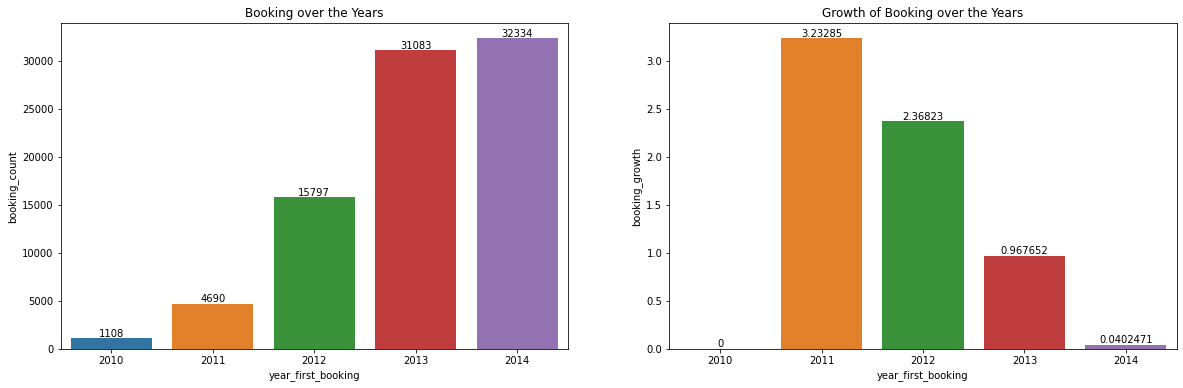

In [48]:
plt.figure(figsize=(20,6))

# select data with complete years and with booking
aux = df04_users[(df04_users['country_destination'] != 'NDF') & 
                  (df04_users['year_first_booking'] < df04_users['year_first_booking'].max())]

# number of booking for each year
aux1 = aux[['year_first_booking']].groupby('year_first_booking').size().reset_index().rename(columns={0: 'booking_count'})

# growth of booking over the years
aux1[['booking_growth']] = aux1[['booking_count']].pct_change().fillna(0)

# number of booking over years
plt.subplot(1, 2, 1)
ax = sns.barplot(x='year_first_booking', y='booking_count', data=aux1 );
ax.bar_label(ax.containers[0]);
plt.title('Booking over the Years');

# growth of booking over the year
plt.subplot(1, 2, 2)
ax = sns.barplot(x='year_first_booking', y='booking_growth', data=aux1);
ax.bar_label(ax.containers[0]);
plt.title('Growth of Booking over the Years');

### H10. Airbnb's booking growth for USA is higher than for other destinations over the years.
**True:** The number of bookings for USA is the highest among all destinations over the years.

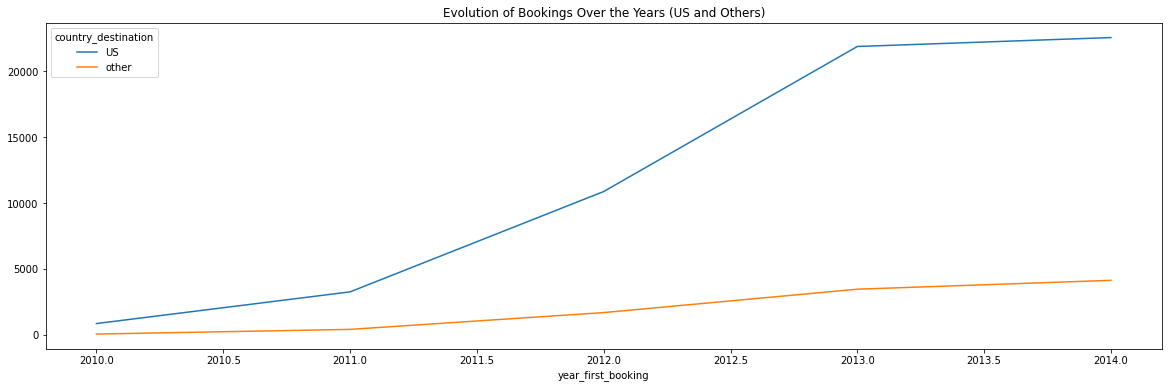

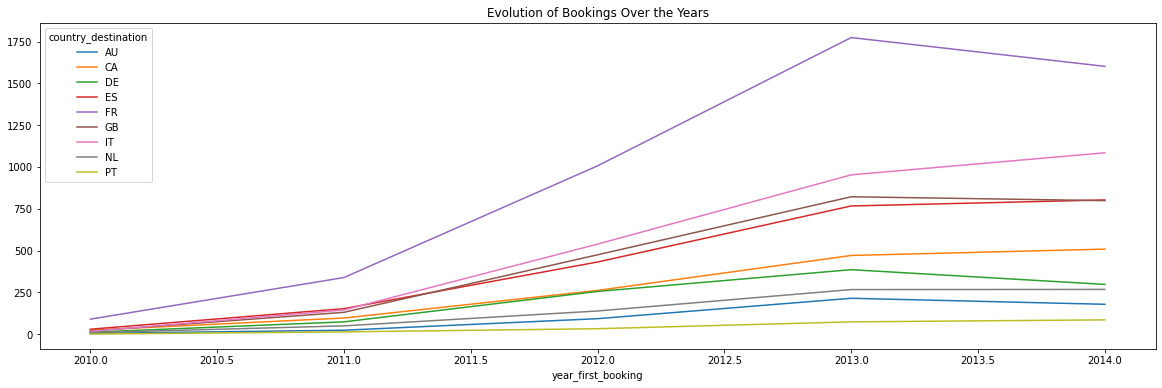

In [49]:
# complete years and with booking
aux = df04_users[(df04_users['country_destination'] != 'NDF') & 
                  (df04_users['year_first_booking'] < df04_users['year_first_booking'].max())]

# number of booking through the year and for each destination
aux1 = aux[['year_first_booking', 'country_destination']].groupby(
    ['year_first_booking', 'country_destination']
).size().reset_index().rename(columns={0: 'booking_count'})

# select data for marjority destinations
aux2 = aux1[(aux1['country_destination'] == 'US') | (aux1['country_destination'] == 'other') ]

aux2.pivot_table(values='booking_count', 
                 index='year_first_booking', 
                 columns='country_destination',
                 aggfunc='sum', 
                 fill_value=0).plot(figsize=(20,6), title='Evolution of Bookings Over the Years (US and Others)');

aux3 = aux1[(aux1['country_destination'] != 'US') & (aux1['country_destination'] != 'other') ]

aux3.pivot_table(values='booking_count', 
                 index='year_first_booking', 
                 columns='country_destination',
                 aggfunc='sum', 
                 fill_value=0).plot(figsize=(20,6), title='Evolution of Bookings Over the Years');

## 4.3. Multivariate Analysis

### 4.3.1. High Correlation Attributes

**Numerical Variables**

diff_first_booking_account_created x diff_first_active_first_booking
    
    remove: diff_first_active_first_booking
    
year_account_created x year_first_active

    remove: year_first_active
        
month_account_created x weekofyear_account_created

    remove: weekofyear_account_created
    
month_account_created x month_first_active

    remove: month_first_active

month_account_created x weekofyear_first_active

    remove: weekofyear_first_active
    
day_account_created x day_first_active

    remove: day_first_active
    
dayofweek_account_created x dayofweek_first_active

    remove: dayofweek_first_active
    
weekofyear_account_created x month_first_active
    
    remove: month_first_active

weekofyear_account_created x weekofyear_first_active

    remove: weekofyear_first_active
    
month_first_active x weekofyear_first_active

    remove: weekofyear_first_active
    
month_first_booking x weekofyear_first_booking

    remove: weekofyear_first_booking

**Categorical Variables**

affiliate_channel x affiliate_provider

    remove: affiliate_provider

signup_app x first_device_type

    remove: first_device_type

first_device_type x first_browser

    remove: first_browser

### 4.3.2. Manual Attributes Selection

In [38]:
# high correlation columns
cols_correlation = ['diff_first_active_first_booking',
                    'year_first_active',
                    'weekofyear_account_created',
                    'month_first_active',
                    'day_first_active',
                    'dayofweek_first_active',
                    'weekofyear_first_active',
                    'weekofyear_first_booking',
                    'affiliate_provider',
                    'first_device_type',
                    'first_browser']

# columns with a unique value (>95%)
cols_unique_values = ['language']

# columns to be manual droped
cols_manual_select = cols_correlation + cols_unique_values

# 5.0. Data Preparation

In [39]:
df05_users = df04_users.copy()

## 5.1. Encoding

In [40]:
df05_users.select_dtypes(exclude=['int64', 'float64']).dtypes

gender                     object
signup_method              object
language                   object
affiliate_channel          object
affiliate_provider         object
first_affiliate_tracked    object
signup_app                 object
first_device_type          object
first_browser              object
country_destination        object
dtype: object

In [41]:
te = TargetEncoder()

c = {'NDF': 0, 'US': 1, 'other': 2, 'CA': 3, 'FR': 4, 'ES': 5, 'GB': 6, 'IT': 7, 'PT': 8, 'NL': 9, 'DE':10, 'AU': 11}

In [42]:
# gender - One Hot Encoder
df05_users = pd.get_dummies(df05_users, prefix=['gender'], columns=['gender'])

# signup_method - One Hot Enconder
df05_users = pd.get_dummies(df05_users, prefix=['signup_method'], columns=['signup_method'])

# signup_app - One Hot Encoder
df05_users = pd.get_dummies(df05_users, prefix=['signup_app'], columns=['signup_app'])

# affiliate_channel - Target Encoder
df05_users['affiliate_channel'] = te.fit_transform(df05_users[['affiliate_channel']].values, 
                                                   df05_users['country_destination'].map(c))

# first_affiliate_tracked - Target Encoder
df05_users['first_affiliate_tracked'] = te.fit_transform(df05_users[['first_affiliate_tracked']].values, 
                                                         df05_users['country_destination'].map(c))

In [43]:
# language - Target Encoder
df05_users['language'] = te.fit_transform(df05_users[['language']].values, 
                                          df05_users['country_destination'].map(c))

# affiliate_provider - Target Encoder
df05_users['affiliate_provider'] = te.fit_transform(df05_users[['affiliate_provider']].values, 
                                                    df05_users['country_destination'].map(c))

# first_device_type - Target Encoder
df05_users['first_device_type'] = te.fit_transform(df05_users[['first_device_type']].values, 
                                                   df05_users['country_destination'].map(c))

# first_browser - Target Encoder
df05_users['first_browser'] = te.fit_transform(df05_users[['first_browser']].values, 
                                               df05_users['country_destination'].map(c))

## 5.2. Rescaling

In [44]:
df05_users.select_dtypes(include=['int64', 'float64']).dtypes

age                                     int64
signup_flow                             int64
language                              float64
affiliate_channel                     float64
affiliate_provider                    float64
first_affiliate_tracked               float64
first_device_type                     float64
first_browser                         float64
diff_account_created_first_active       int64
diff_first_booking_account_created      int64
diff_first_active_first_booking         int64
year_account_created                    int64
month_account_created                   int64
day_account_created                     int64
dayofweek_account_created               int64
weekofyear_account_created              int64
year_first_active                       int64
month_first_active                      int64
day_first_active                        int64
dayofweek_first_active                  int64
weekofyear_first_active                 int64
year_first_booking                

In [45]:
ss = pp.StandardScaler()

rs = pp.RobustScaler()

mms = pp.MinMaxScaler()

In [46]:
# age - Standardization
df05_users['age'] = ss.fit_transform(df05_users[['age']].values)

# signup_flow - Robust Scaler
df05_users['signup_flow'] = rs.fit_transform(df05_users[['signup_flow']].values)

# diff_account_created_first_active - Robust Scaler
df05_users['diff_account_created_first_active'] = rs.fit_transform(df05_users[['diff_account_created_first_active']].values)

# diff_first_booking_account_created -Robust Scaler
df05_users['diff_first_booking_account_created'] = rs.fit_transform(df05_users[['diff_first_booking_account_created']].values)

# year_account_created - Min-Max-Scaler
df05_users['year_account_created'] = mms.fit_transform(df05_users[['year_account_created']].values)

# year_first_booking
df05_users['year_first_booking'] = mms.fit_transform(df05_users[['year_first_booking']].values)

In [47]:
# diff_first_active_first_booking - Robust Scaler
df05_users['diff_first_active_first_booking'] = rs.fit_transform(df05_users[['diff_first_active_first_booking']].values)

# year_first_active - Min-Max-Scaler
df05_users['year_first_active'] = mms.fit_transform(df05_users[['year_first_active']].values)

## 5.3. Transformation

In [48]:
df05_users.select_dtypes(include=['int64', 'float64']).dtypes

age                                   float64
signup_flow                           float64
language                              float64
affiliate_channel                     float64
affiliate_provider                    float64
first_affiliate_tracked               float64
first_device_type                     float64
first_browser                         float64
diff_account_created_first_active     float64
diff_first_booking_account_created    float64
diff_first_active_first_booking       float64
year_account_created                  float64
month_account_created                   int64
day_account_created                     int64
dayofweek_account_created               int64
weekofyear_account_created              int64
year_first_active                     float64
month_first_active                      int64
day_first_active                        int64
dayofweek_first_active                  int64
weekofyear_first_active                 int64
year_first_booking                

In [49]:
# month_account_created
df05_users['month_account_created_sin'] = df05_users['month_account_created'].apply(lambda x: np.sin(x*(2*np.pi/52)))
df05_users['month_account_created_cos'] = df05_users['month_account_created'].apply(lambda x: np.cos(x*(2*np.pi/52)))

# day_account_created
df05_users['day_account_created_sin'] = df05_users['day_account_created'].apply(lambda x: np.sin(x*(2*np.pi/31)))
df05_users['day_account_created_cos'] = df05_users['day_account_created'].apply(lambda x: np.cos(x*(2*np.pi/31)))

# dayofweek_account_created
df05_users['dayofweek_account_created_sin'] = df05_users['dayofweek_account_created'].apply(lambda x: np.sin(x*(2*np.pi/7)))
df05_users['dayofweek_account_created_cos'] = df05_users['dayofweek_account_created'].apply(lambda x: np.cos(x*(2*np.pi/7)))

# month_first_booking
df05_users['month_first_booking_sin'] = df05_users['month_first_booking'].apply(lambda x: np.sin(x*(2*np.pi/12)))
df05_users['month_first_booking_cos'] = df05_users['month_first_booking'].apply(lambda x: np.cos(x*(2*np.pi/12)))

# day_first_booking
df05_users['day_first_booking_sin'] = df05_users['day_first_booking'].apply(lambda x: np.sin(x*(2*np.pi/31)))
df05_users['day_first_booking_cos'] = df05_users['day_first_booking'].apply(lambda x: np.cos(x*(2*np.pi/31)))

# dayofweek_first_booking
df05_users['dayofweek_first_booking_sin'] = df05_users['dayofweek_first_booking'].apply(lambda x: np.sin(x*(2*np.pi/7)))
df05_users['dayofweek_first_booking_cos'] = df05_users['dayofweek_first_booking'].apply(lambda x: np.cos(x*(2*np.pi/7)))

In [50]:
# weekofyear_account_created
df05_users['weekofyear_account_created_sin'] = df05_users['weekofyear_account_created'].apply(lambda x: np.sin(x*(2*np.pi/52))) 
df05_users['weekofyear_account_created_sin'] = df05_users['weekofyear_account_created'].apply(lambda x: np.cos(x*(2*np.pi/52))) 

# month_first_active
df05_users['month_first_active_sin'] = df05_users['month_first_active'].apply(lambda x: np.sin(x*(2*np.pi/12)))
df05_users['month_first_active_cos'] = df05_users['month_first_active'].apply(lambda x: np.cos(x*(2*np.pi/12)))

# day_first_active
df05_users['day_first_active_sin'] = df05_users['day_first_active'].apply(lambda x: np.sin(x*(2*np.pi/31)))
df05_users['day_first_active_cos'] = df05_users['day_first_active'].apply(lambda x: np.cos(x*(2*np.pi/31)))

# dayofweek_first_active
df05_users['dayofweek_first_active_sin'] = df05_users['dayofweek_first_active'].apply(lambda x: np.sin(x*(2*np.pi/7)))
df05_users['dayofweek_first_active_cos'] = df05_users['dayofweek_first_active'].apply(lambda x: np.cos(x*(2*np.pi/7)))

# weekofyear_first_active
df05_users['weekofyear_first_active_sin'] = df05_users['weekofyear_first_active'].apply(lambda x: np.sin(x*(2*np.pi/52)))
df05_users['weekofyear_first_active_cos'] = df05_users['weekofyear_first_active'].apply(lambda x: np.cos(x*(2*np.pi/52)))

# weekofyear_first_booking
df05_users['weekofyear_first_booking_sin'] = df05_users['weekofyear_first_booking'].apply(lambda x: np.sin(x*(2*np.pi/52)))
df05_users['weekofyear_first_booking_cos'] = df05_users['weekofyear_first_booking'].apply(lambda x: np.cos(x*(2*np.pi/52)))

In [51]:
cols_transform = ['month_account_created', 'day_account_created', 'dayofweek_account_created', 
                  'month_first_booking', 'day_first_booking', 'dayofweek_first_booking', 'weekofyear_account_created', 
                  'month_first_active', 'day_first_active', 'dayofweek_first_active', 'weekofyear_first_active', 
                  'weekofyear_first_booking']

df05_users = df05_users.drop(columns=cols_transform)

## 5.4. Response Variable

In [52]:
# create OneHotEncoder instance
ohe = pp.OneHotEncoder()

# ohe hot encoding response feature
df_ohe = pd.DataFrame(ohe.fit_transform(df05_users['country_destination'].values.reshape(-1,1)).toarray(),
                      columns=ohe.categories_[0],
                      index=df05_users.index)

# joining encoded response feature to dataset
df05_users = pd.concat([df05_users.drop(columns=['country_destination']), df_ohe], axis=1)

# 6.0. Feature Selection

In [61]:
df06_users = df05_users.copy()

## 6.1. Split Dataframe into Training and Test Dataset

In [62]:
# training dataset
X = df06_users.drop( columns=ohe.categories_[0] )

#  training response dataset
y = df06_users[ohe.categories_[0]]

In [63]:
# Split dataset into training and test (validation)
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=32)

## 6.2. Balanced Dataset

### 6.2.1. Random Undersampling

In [64]:
# define sampler - random under-sampling
undersampling = us.RandomUnderSampler(sampling_strategy='not minority', random_state=32)

# resample the dataset
X_train_under, y_train_under = undersampling.fit_resample(X_train, ohe.inverse_transform(y_train))

In [65]:
pd.DataFrame(ohe.inverse_transform(y_train)).value_counts()

NDF      95544
US       47937
other     7851
FR        3877
IT        2203
GB        1790
ES        1750
CA        1086
DE         797
NL         583
AU         421
PT         176
dtype: int64

In [66]:
pd.DataFrame(y_train_under).value_counts()

AU       176
CA       176
DE       176
ES       176
FR       176
GB       176
IT       176
NDF      176
NL       176
PT       176
US       176
other    176
dtype: int64

In [67]:
# convert back to encoding representation
y_train_under = pd.DataFrame(ohe.transform(y_train_under.reshape(-1,1)).toarray(), 
                             columns=ohe.categories_[0], 
                             index=X_train_under.index)

### 6.2.2. Random Oversampling

In [68]:
# define sampler - random over-sampling
oversampling = osamp.RandomOverSampler(sampling_strategy='not majority', random_state=32)

# resample the dataset
X_train_over, y_train_over = oversampling.fit_resample(X_train, ohe.inverse_transform(y_train))

In [69]:
pd.DataFrame(ohe.inverse_transform(y_train)).value_counts()

NDF      95544
US       47937
other     7851
FR        3877
IT        2203
GB        1790
ES        1750
CA        1086
DE         797
NL         583
AU         421
PT         176
dtype: int64

In [70]:
pd.DataFrame(y_train_over).value_counts()

AU       95544
CA       95544
DE       95544
ES       95544
FR       95544
GB       95544
IT       95544
NDF      95544
NL       95544
PT       95544
US       95544
other    95544
dtype: int64

In [71]:
# convert back to encoding representation
y_train_over = pd.DataFrame(ohe.transform(y_train_over.reshape(-1,1)).toarray(), 
                            columns=ohe.categories_[0], 
                            index=X_train_over.index)

### 6.2.3. SMOTE + TOMEKLINK

In [72]:
# define sampler - over-sampling using SMOTE and cleaning using Tomek links
combine = comb.SMOTETomek(sampling_strategy='auto', random_state=32, n_jobs=-1)

# resample the dataset
X_train_comb, y_train_comb = combine.fit_resample(X_train, ohe.inverse_transform(y_train))

In [73]:
pd.DataFrame(ohe.inverse_transform(y_train)).value_counts()

NDF      95544
US       47937
other     7851
FR        3877
IT        2203
GB        1790
ES        1750
CA        1086
DE         797
NL         583
AU         421
PT         176
dtype: int64

In [74]:
pd.DataFrame(y_train_comb).value_counts()

AU       95543
NL       95541
NDF      95535
DE       95532
PT       95532
CA       95529
ES       95496
GB       95477
IT       95477
FR       95409
other    95203
US       95166
dtype: int64

In [75]:
# convert back to encoding representation
y_train_comb = pd.DataFrame(ohe.transform(y_train_comb.reshape(-1,1)).toarray(), 
                            columns=ohe.categories_[0], 
                            index=X_train_comb.index)

## 6.3. Manual Selection - Exploratory Data Analysis

In [76]:
# transform columns name in new format after transformation
cols_manual_select_transform = cols_manual_select.copy()

# list of attributes transform im section 5.3.
cols_transform = ['weekofyear_account_created_sin', 'weekofyear_account_created_sin',
                  'month_first_active_sin', 'month_first_active_cos',
                  'day_first_active_sin', 'day_first_active_cos',
                  'dayofweek_first_active_sin', 'dayofweek_first_active_cos', 
                  'weekofyear_first_active_sin', 'weekofyear_first_active_cos',
                  'weekofyear_first_booking_sin', 'weekofyear_first_booking_cos']

# add atributes transform
for attributes in cols_transform:
    cols_manual_select_transform.append(attributes)

# attributes select to be discard in EDA
cols_discard = ['weekofyear_first_active', 'day_first_active', 'dayofweek_first_active', 
                'weekofyear_first_booking', 'weekofyear_account_created', 'month_first_active']

# remove atributes select in EDA
for attributes in cols_discard:
    cols_manual_select_transform.remove(attributes)

In [77]:
# imbalanced dataset
X_train_manual_select = X_train.drop(columns=cols_manual_select_transform)
X_test_manual_select = X_test.drop(columns=cols_manual_select_transform)

# random undersampling
X_train_under_manual_select = X_train_under.drop(columns=cols_manual_select_transform)

# random oversampling
X_train_over_manual_select = X_train_over.drop(columns=cols_manual_select_transform)

# SMOTE + Tomek Links
X_train_comb_manual_select = X_train_comb.drop(columns=cols_manual_select_transform)

# 7.0. Machine Learning Model

In [78]:
# imbalanced dataset
x_train = X_train
x_test = X_test

# random uindersampling
x_train_under = X_train_under

# random oversampling
x_train_over = X_train_over

# SMOTE + TOMEK Links
x_train_comb = X_train_comb

## 7.1. Baseline Model - Random

In [79]:
# list of country destination
country_list = ohe.categories_[0].tolist()

# number of rows
k_num = y_test.shape[0]

# proportion of country destinations for imbalanced result
df_ohe = pd.DataFrame(ohe.inverse_transform(df06_users[ohe.categories_[0]]))
country_weights = df_ohe.value_counts(normalize=True).sort_index().tolist()

# prediction
yhat_random = random.choices(population=country_list,
                             weights=country_weights,
                             k=k_num)

# invert validation response
y_test_random = ohe.inverse_transform(y_test)

### 7.1.1. Baseline Model - Performance

Accuracy 0.4248609891717881
Balanced Accuracy: 0.08206407724189317
Kappa Score: -0.002191498299420891
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00        98
          CA       0.01      0.01      0.01       283
          DE       0.00      0.00      0.00       227
          ES       0.01      0.01      0.01       433
          FR       0.02      0.02      0.02       963
          GB       0.01      0.01      0.01       469
          IT       0.01      0.01      0.01       539
         NDF       0.57      0.58      0.58     23643
          NL       0.00      0.00      0.00       156
          PT       0.00      0.00      0.00        36
          US       0.30      0.30      0.30     12192
       other       0.05      0.05      0.05      1965

    accuracy                           0.42     41004
   macro avg       0.08      0.08      0.08     41004
weighted avg       0.42      0.42      0.42     41004



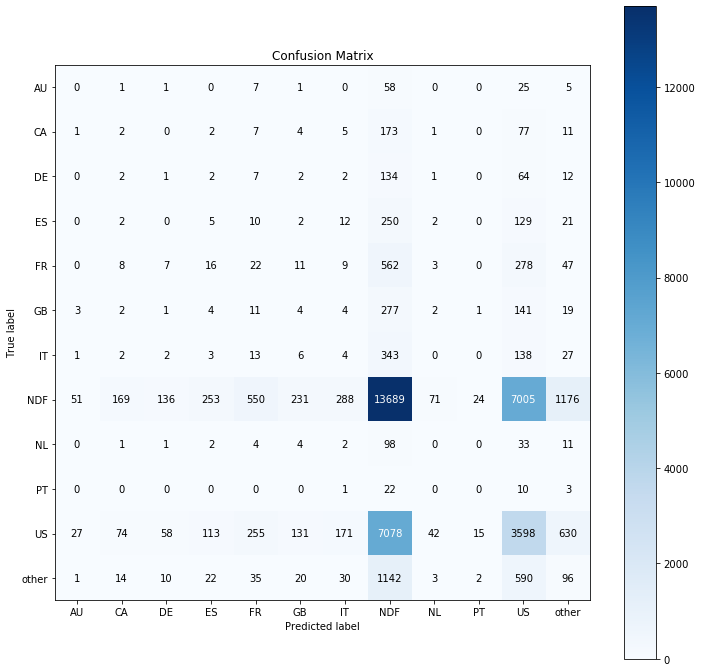

In [80]:
# Accuracy
acc_random = m.accuracy_score( y_test_random, yhat_random )
print(f'Accuracy {acc_random}')

# Balanced Accuracy
balanced_acc_random = m.balanced_accuracy_score(y_test_random, yhat_random)
print(f'Balanced Accuracy: {balanced_acc_random}')

# Kappa Metrics
kappa_random = m.cohen_kappa_score(y_test_random, yhat_random)
print(f'Kappa Score: {kappa_random}')

# Classification report
print(m.classification_report(y_test_random, yhat_random))

# Confusion Matrix
mt.plot_confusion_matrix(y_test_random, yhat_random, normalize=False, figsize=(12,12));

# Performance
baseline_performance = {'model': 'Baseline Model', 
                        'acc': acc_random, 
                        'balanced_acc': balanced_acc_random, 
                        'kappa_store': kappa_random}

## 7.2. Neural Network - MLP

### 7.2.1. Neural Network - Imbalanced Data

In [81]:
# model definition
model_nn = ml.Sequential()
model_nn.add( l.Dense(128, input_dim=x_train.shape[1], activation='relu') )
model_nn.add( l.Dense(12, activation='softmax') )

# model compile
model_nn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train model
model_nn.fit(x_train, y_train, epochs=100)

Epoch 1/100
5126/5126 [==============================] - 9s 2ms/step - loss: 0.5214 - accuracy: 0.8712
Epoch 2/100
5126/5126 [==============================] - 7s 1ms/step - loss: 0.5004 - accuracy: 0.8744
Epoch 3/100
5126/5126 [==============================] - 7s 1ms/step - loss: 0.4945 - accuracy: 0.8745: 0s - loss:
Epoch 4/100
5126/5126 [==============================] - 9s 2ms/step - loss: 0.4874 - accuracy: 0.8746: 0s - loss: 0.4878 - accura
Epoch 5/100
5126/5126 [==============================] - 8s 2ms/step - loss: 0.4855 - accuracy: 0.8746: 0s - loss: 0
Epoch 6/100
5126/5126 [==============================] - 9s 2ms/step - loss: 0.4844 - accuracy: 0.8746
Epoch 7/100
5126/5126 [==============================] - 9s 2ms/step - loss: 0.4833 - accuracy: 0.8747
Epoch 8/100
5126/5126 [==============================] - 7s 1ms/step - loss: 0.4818 - accuracy: 0.8747
Epoch 9/100
5126/5126 [==============================] - 8s 2ms/step - loss: 0.4813 - accuracy: 0.8747
Epoch 10/100
5126/5

5126/5126 [==============================] - 8s 1ms/step - loss: 0.4696 - accuracy: 0.8749: 1s - loss: 0.4709 - ac
Epoch 78/100
5126/5126 [==============================] - 6s 1ms/step - loss: 0.4692 - accuracy: 0.8750
Epoch 79/100
5126/5126 [==============================] - 9s 2ms/step - loss: 0.4734 - accuracy: 0.8749: 0s - loss: 0.4736 - accu
Epoch 80/100
5126/5126 [==============================] - 6s 1ms/step - loss: 0.4688 - accuracy: 0.8749
Epoch 81/100
5126/5126 [==============================] - 7s 1ms/step - loss: 0.4700 - accuracy: 0.8748
Epoch 82/100
5126/5126 [==============================] - 7s 1ms/step - loss: 0.4713 - accuracy: 0.8749
Epoch 83/100
5126/5126 [==============================] - 6s 1ms/step - loss: 0.4701 - accuracy: 0.8748
Epoch 84/100
5126/5126 [==============================] - 7s 1ms/step - loss: 0.4681 - accuracy: 0.8748
Epoch 85/100
5126/5126 [==============================] - 8s 2ms/step - loss: 0.4691 - accuracy: 0.8749
Epoch 86/100
5126/5126 [===

#### 7.2.1.1 Imbalanced Data - Performance

In [82]:
# prediction
pred_nn = model_nn.predict(x_test)

# invert prediction
yhat_nn = ohe.inverse_transform(pred_nn)

# invert validation response
y_test_nn = ohe.inverse_transform(y_test)

In [83]:
# check the balance of validation
pd.DataFrame(y_test_nn).value_counts(normalize=True)

NDF      0.576602
US       0.297337
other    0.047922
FR       0.023486
IT       0.013145
GB       0.011438
ES       0.010560
CA       0.006902
DE       0.005536
NL       0.003805
AU       0.002390
PT       0.000878
dtype: float64

In [84]:
# check the balance of result
pd.DataFrame(yhat_nn).value_counts(normalize=True)

NDF      0.576871
US       0.422081
other    0.000366
GB       0.000317
DE       0.000122
AU       0.000073
CA       0.000073
IT       0.000049
ES       0.000024
FR       0.000024
dtype: float64

Accuracy: 0.873012389035216
Balanced Accuracy: 0.16674862936909007
Kappa Score: 0.765641077249041
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00        98
          CA       0.00      0.00      0.00       283
          DE       0.00      0.00      0.00       227
          ES       0.00      0.00      0.00       433
          FR       0.00      0.00      0.00       963
          GB       0.15      0.00      0.01       469
          IT       0.00      0.00      0.00       539
         NDF       1.00      1.00      1.00     23643
          NL       0.00      0.00      0.00       156
          PT       0.00      0.00      0.00        36
          US       0.70      1.00      0.82     12192
       other       0.00      0.00      0.00      1965

    accuracy                           0.87     41004
   macro avg       0.15      0.17      0.15     41004
weighted avg       0.79      0.87      0.82     41004



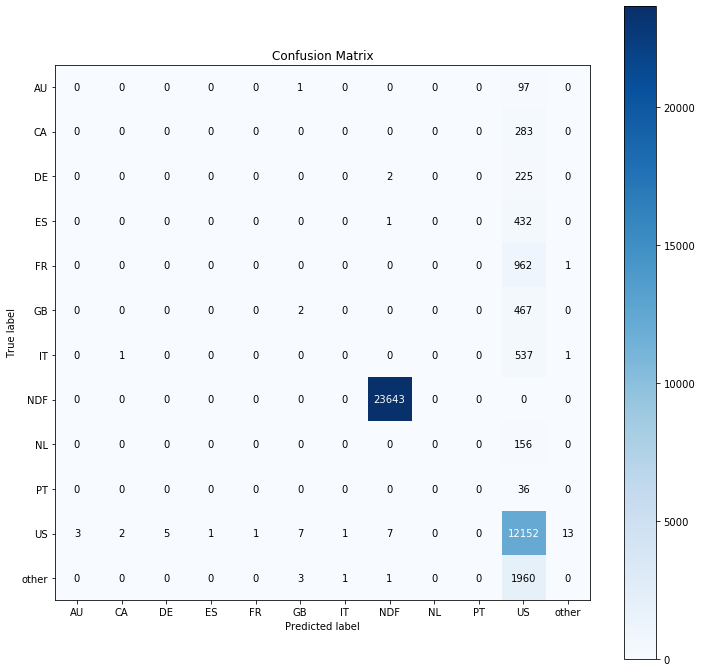

In [86]:
# Accuracy
acc_nn = m.accuracy_score( y_test_nn, yhat_nn )
print(f'Accuracy: {acc_nn}')

# Balanced Accuracy
balanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
print(f'Balanced Accuracy: {balanced_acc_nn}')

# Kappa Metrics
kappa_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
print(f'Kappa Score: {kappa_nn}')

# Classification report
print(m.classification_report(y_test_nn, yhat_nn))

# Confusion Matrix
mt.plot_confusion_matrix( y_test_nn, yhat_nn, normalize=False, figsize=(12,12));

# Performance
imb_performance = {'model': 'NN Model - Imbalanced Data',
                   'acc': np.round(acc_nn, 6), 
                   'balanced_acc': np.round(balanced_acc_nn, 6), 
                   'kappa_score': np.round(kappa_nn, 6)}

#### 7.2.1.2. Imbalanced Data - Cross-Validation

In [87]:
# cross validation performance
acc_nn, balanced_acc_nn, kappa_nn = cross_validation(num_fold = 5, 
                                                     x_train = x_train, 
                                                     y_train = y_train, 
                                                     model = model_nn, 
                                                     response_encoder = ohe, 
                                                     balance_model = False, 
                                                     verbose = True)

Fold Number:1/5
Fold Number:2/5
Fold Number:3/5
Fold Number:4/5
Fold Number:5/5


In [88]:
# Performance
imb_performance_cv = {'model': 'NN Model - Imbalanced Data - CV',
                      'acc': f'{np.round(np.mean(acc_nn), 2)} +/- {np.round(np.std(acc_nn), 4)}',
                      'balanced_acc': f'{np.round(np.mean(balanced_acc_nn), 2)} +/- {np.round(np.std(balanced_acc_nn), 4)}',
                      'kappa_score': f'{np.round(np.mean(kappa_nn), 2)} +/- {np.round(np.std(kappa_nn), 4)}'}

In [89]:
print(f'Avg Accuracy: {np.round(np.mean(acc_nn), 2)} +/- {np.round(np.std(acc_nn),5)}')
print(f'Avg Balanced Accuracy: {np.round(np.mean(balanced_acc_nn), 2)} +/- {np.round(np.std(balanced_acc_nn),5)}')
print(f'Avg Kappa Score: {np.round(np.mean(kappa_nn), 2)} +/- {np.round(np.std(kappa_nn), 4)}')

Avg Accuracy: 0.87 +/- 0.00031
Avg Balanced Accuracy: 0.17 +/- 0.00046
Avg Kappa Score: 0.77 +/- 0.0005


### 7.2.2. Neural Network - Random Undersampling

In [90]:
# model definition
model_under = ml.Sequential()
model_under.add( l.Dense(128, input_dim=x_train_under.shape[1], activation='relu') )
model_under.add( l.Dense(12, activation='softmax') )

# model compile
model_under.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train model
model_under.fit(x_train_under, y_train_under, epochs=100)

Epoch 1/100
66/66 [==============================] - 0s 1ms/step - loss: 2.5576 - accuracy: 0.1468
Epoch 2/100
66/66 [==============================] - 0s 1ms/step - loss: 2.3372 - accuracy: 0.1903
Epoch 3/100
66/66 [==============================] - 0s 1ms/step - loss: 2.2721 - accuracy: 0.2055
Epoch 4/100
66/66 [==============================] - 0s 1ms/step - loss: 2.2245 - accuracy: 0.2173
Epoch 5/100
66/66 [==============================] - 0s 1ms/step - loss: 2.1904 - accuracy: 0.2263
Epoch 6/100
66/66 [==============================] - 0s 1ms/step - loss: 2.1651 - accuracy: 0.2344
Epoch 7/100
66/66 [==============================] - 0s 1ms/step - loss: 2.1625 - accuracy: 0.2344
Epoch 8/100
66/66 [==============================] - 0s 1ms/step - loss: 2.1505 - accuracy: 0.2543
Epoch 9/100
66/66 [==============================] - 0s 1ms/step - loss: 2.1261 - accuracy: 0.2533
Epoch 10/100
66/66 [==============================] - 0s 1ms/step - loss: 2.1150 - accuracy: 0.2604
Epoch 11/

66/66 [==============================] - 0s 2ms/step - loss: 1.6220 - accuracy: 0.4517
Epoch 84/100
66/66 [==============================] - 0s 1ms/step - loss: 1.6348 - accuracy: 0.4612
Epoch 85/100
66/66 [==============================] - 0s 1ms/step - loss: 1.6379 - accuracy: 0.4474
Epoch 86/100
66/66 [==============================] - 0s 1ms/step - loss: 1.6280 - accuracy: 0.4545
Epoch 87/100
66/66 [==============================] - 0s 1ms/step - loss: 1.6140 - accuracy: 0.4621
Epoch 88/100
66/66 [==============================] - 0s 2ms/step - loss: 1.6240 - accuracy: 0.4645
Epoch 89/100
66/66 [==============================] - 0s 2ms/step - loss: 1.6206 - accuracy: 0.4744
Epoch 90/100
66/66 [==============================] - 0s 1ms/step - loss: 1.5988 - accuracy: 0.4664
Epoch 91/100
66/66 [==============================] - 0s 1ms/step - loss: 1.6087 - accuracy: 0.4673
Epoch 92/100
66/66 [==============================] - 0s 1ms/step - loss: 1.5985 - accuracy: 0.4744
Epoch 93/100


#### 7.2.2.1. Random Undersampling - Performance

In [91]:
# prediction
pred_under_nn = model_under.predict(x_test)

# invert prediction
yhat_under_nn = ohe.inverse_transform(pred_under_nn)

# invert validation response
y_test_under_nn = ohe.inverse_transform(y_test)

In [92]:
# check the balance of validation
pd.DataFrame(y_test_under_nn).value_counts(normalize=True)

NDF      0.576602
US       0.297337
other    0.047922
FR       0.023486
IT       0.013145
GB       0.011438
ES       0.010560
CA       0.006902
DE       0.005536
NL       0.003805
AU       0.002390
PT       0.000878
dtype: float64

In [93]:
# check the balance of validation
pd.DataFrame(yhat_under_nn).value_counts(normalize=True)

NDF      0.576749
AU       0.049971
FR       0.048434
NL       0.047971
DE       0.045532
ES       0.042093
US       0.040118
GB       0.035679
PT       0.035143
IT       0.032241
CA       0.025168
other    0.020900
dtype: float64

Accuracy: 0.6155497024680519
Balanced Accuracy: 0.1775594044128359
Kappa Score: 0.40975734909003036
              precision    recall  f1-score   support

          AU       0.01      0.15      0.01        98
          CA       0.02      0.08      0.03       283
          DE       0.02      0.16      0.04       227
          ES       0.03      0.11      0.04       433
          FR       0.06      0.12      0.08       963
          GB       0.03      0.10      0.05       469
          IT       0.04      0.09      0.05       539
         NDF       1.00      1.00      1.00     23643
          NL       0.01      0.09      0.01       156
          PT       0.00      0.08      0.00        36
          US       0.71      0.10      0.17     12192
       other       0.12      0.05      0.07      1965

    accuracy                           0.62     41004
   macro avg       0.17      0.18      0.13     41004
weighted avg       0.79      0.62      0.63     41004



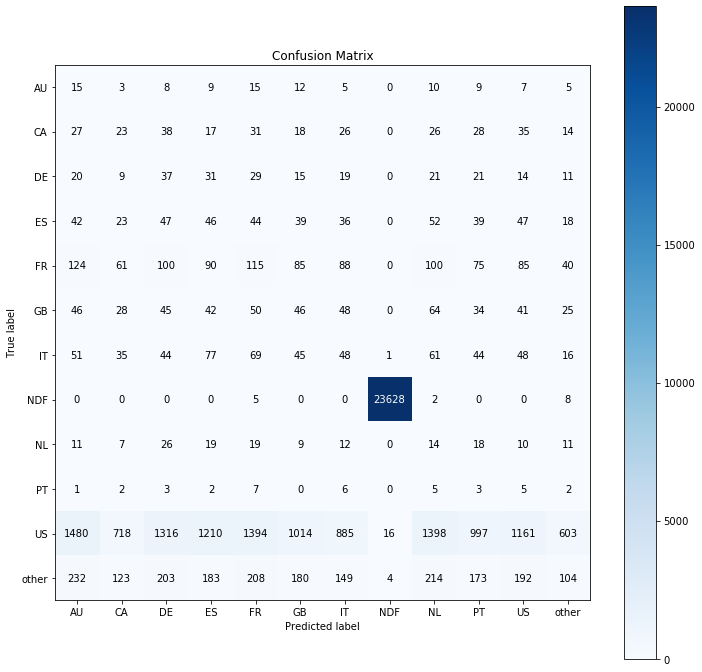

In [95]:
# Accuracy
acc_under_nn = m.accuracy_score( y_test_under_nn, yhat_under_nn )
print(f'Accuracy: {acc_under_nn}')

# Balanced Accuracy
balanced_acc_under_nn = m.balanced_accuracy_score(y_test_under_nn, yhat_under_nn)
print(f'Balanced Accuracy: {balanced_acc_under_nn}')

# Kappa Metrics
kappa_under_nn = m.cohen_kappa_score(y_test_under_nn, yhat_under_nn)
print(f'Kappa Score: {kappa_under_nn}')

# Classification report
print(m.classification_report(y_test_under_nn, yhat_under_nn))

# Confusion Matrix
mt.plot_confusion_matrix( y_test_under_nn, yhat_under_nn, normalize=False, figsize=(12,12));

# Performance
under_performance = {'model': 'NN Model - Random Undersampling',
                     'acc': np.round(acc_under_nn, 6),
                     'balanced_acc': np.round(balanced_acc_under_nn, 6),
                     'kappa_score': np.round(kappa_under_nn, 6)}

#### 7.2.2.2. Random Undersampling - Cross-Validation

In [96]:
# cross validation performance
acc_under, balanced_acc_under, kappa_under = cross_validation(num_fold = 5, 
                                                              x_train = x_train, 
                                                              y_train = y_train, 
                                                              model = model_under, 
                                                              response_encoder = ohe, 
                                                              balance_model = undersampling, 
                                                              verbose = True)

Fold Number:1/5
Fold Number:2/5
Fold Number:3/5
Fold Number:4/5
Fold Number:5/5


In [97]:
# Performance
under_performance_cv = {'model': 'NN Model - Random Undersampling - CV',
                        'acc': f'{np.round(np.mean(acc_under), 2)} +/- {np.round(np.std(acc_under), 4)}',
                        'balanced_acc': f'{np.round(np.mean(balanced_acc_under), 2)} +/- {np.round(np.std(balanced_acc_under), 4)}',
                        'kappa_score': f'{np.round(np.mean(kappa_under), 2)} +/- {np.round(np.std(kappa_under), 4)}'}

In [98]:
print(f'Avg Accuracy: {np.round(np.mean(acc_under), 2)} +/- {np.round(np.std(acc_under),5)}')
print(f'Avg Balanced Accuracy: {np.round(np.mean(balanced_acc_under), 2)} +/- {np.round(np.std(balanced_acc_under),5)}')
print(f'Avg Kappa Score: {np.round(np.mean(kappa_under), 2)} +/- {np.round(np.std(kappa_under), 4)}')

Avg Accuracy: 0.63 +/- 0.00392
Avg Balanced Accuracy: 0.21 +/- 0.01381
Avg Kappa Score: 0.42 +/- 0.0046


### 7.2.3. Neural Network - Random Oversampling

In [99]:
# model definition
model_over = ml.Sequential()
model_over.add( l.Dense(128, input_dim=x_train_over.shape[1], activation='relu') )
model_over.add( l.Dense(12, activation='softmax') )

# model compile
model_over.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train model
model_over.fit(x_train_over, y_train_over, epochs=100)

Epoch 1/100
35829/35829 [==============================] - 86s 2ms/step - loss: 1.9186 - accuracy: 0.3261
Epoch 2/100
35829/35829 [==============================] - 40s 1ms/step - loss: 1.7362 - accuracy: 0.3882
Epoch 3/100
35829/35829 [==============================] - 34s 945us/step - loss: 1.6733 - accuracy: 0.4096
Epoch 4/100
35829/35829 [==============================] - 33s 923us/step - loss: 1.6406 - accuracy: 0.4208
Epoch 5/100
35829/35829 [==============================] - 32s 895us/step - loss: 1.6193 - accuracy: 0.4284
Epoch 6/100
35829/35829 [==============================] - 32s 898us/step - loss: 1.6043 - accuracy: 0.4329
Epoch 7/100
35829/35829 [==============================] - 32s 893us/step - loss: 1.5929 - accuracy: 0.4361
Epoch 8/100
35829/35829 [==============================] - 32s 893us/step - loss: 1.5821 - accuracy: 0.4390
Epoch 9/100
35829/35829 [==============================] - 32s 896us/step - loss: 1.5736 - accuracy: 0.4411
Epoch 10/100
35829/35829 [======

35829/35829 [==============================] - 53s 1ms/step - loss: 1.4708 - accuracy: 0.4685
Epoch 76/100
35829/35829 [==============================] - 47s 1ms/step - loss: 1.4697 - accuracy: 0.4689
Epoch 77/100
35829/35829 [==============================] - 38s 1ms/step - loss: 1.4690 - accuracy: 0.4693
Epoch 78/100
35829/35829 [==============================] - 37s 1ms/step - loss: 1.4698 - accuracy: 0.4693
Epoch 79/100
35829/35829 [==============================] - 54s 2ms/step - loss: 1.4697 - accuracy: 0.4694
Epoch 80/100
35829/35829 [==============================] - 70s 2ms/step - loss: 1.4688 - accuracy: 0.4696
Epoch 81/100
35829/35829 [==============================] - 57s 2ms/step - loss: 1.4682 - accuracy: 0.4693
Epoch 82/100
35829/35829 [==============================] - 46s 1ms/step - loss: 1.4674 - accuracy: 0.4697
Epoch 83/100
35829/35829 [==============================] - 45s 1ms/step - loss: 1.4657 - accuracy: 0.4700 
Epoch 84/100
35829/35829 [=======================

#### 7.2.3.1. Random Oversampling - Performance

In [100]:
# prediction
pred_over_nn = model_over.predict(x_test)

# invert prediction
yhat_over_nn = ohe.inverse_transform(pred_over_nn)

# invert validation response
y_test_over_nn = ohe.inverse_transform(y_test)

In [101]:
# check the balance of validation
pd.DataFrame(y_test_over_nn).value_counts(normalize=True)

NDF      0.576602
US       0.297337
other    0.047922
FR       0.023486
IT       0.013145
GB       0.011438
ES       0.010560
CA       0.006902
DE       0.005536
NL       0.003805
AU       0.002390
PT       0.000878
dtype: float64

In [102]:
# check the balance of results
pd.DataFrame(yhat_over_nn).value_counts(normalize=True)

NDF      0.576871
FR       0.074920
ES       0.067164
CA       0.065847
DE       0.060287
NL       0.049361
other    0.029973
IT       0.024339
AU       0.021510
GB       0.013389
US       0.009121
PT       0.007219
dtype: float64

Accuracy: 0.5975270705297044
Balanced Accuracy: 0.17306745249295796
Kappa Score: 0.3894998292159614
              precision    recall  f1-score   support

          AU       0.01      0.07      0.01        98
          CA       0.02      0.18      0.03       283
          DE       0.01      0.15      0.03       227
          ES       0.03      0.17      0.05       433
          FR       0.06      0.19      0.09       963
          GB       0.03      0.04      0.04       469
          IT       0.03      0.06      0.04       539
         NDF       1.00      1.00      1.00     23643
          NL       0.01      0.12      0.02       156
          PT       0.00      0.00      0.00        36
          US       0.78      0.02      0.05     12192
       other       0.13      0.08      0.10      1965

    accuracy                           0.60     41004
   macro avg       0.18      0.17      0.12     41004
weighted avg       0.82      0.60      0.60     41004



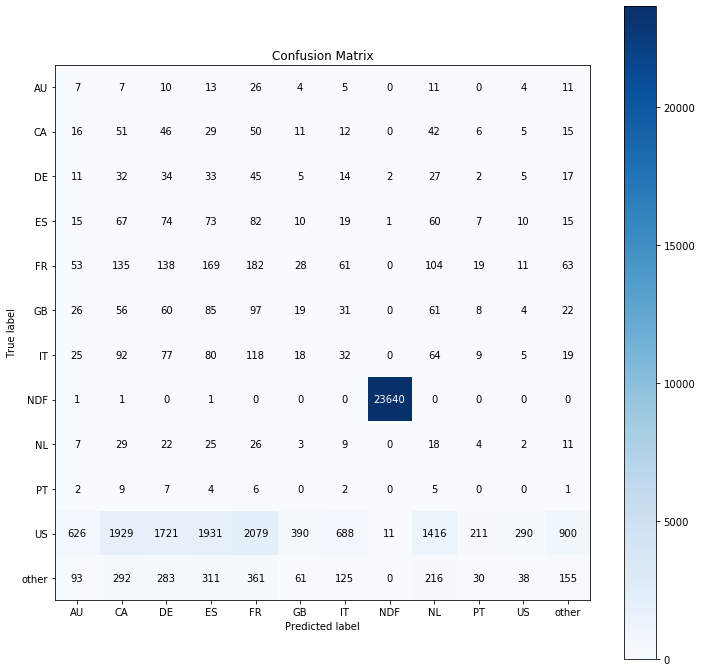

In [104]:
# Accuracy
acc_over_nn = m.accuracy_score( y_test_over_nn, yhat_over_nn )
print(f'Accuracy: {acc_over_nn}')

# Balanced Accuracy
balanced_acc_over_nn = m.balanced_accuracy_score(y_test_over_nn, yhat_over_nn)
print(f'Balanced Accuracy: {balanced_acc_over_nn}')

# Kappa Metrics
kappa_over_nn = m.cohen_kappa_score(y_test_over_nn, yhat_over_nn)
print(f'Kappa Score: {kappa_over_nn}')

# Classification report
print(m.classification_report(y_test_over_nn, yhat_over_nn))

# Confusion Matrix
mt.plot_confusion_matrix( y_test_over_nn, yhat_over_nn, normalize=False, figsize=(12,12));

# Performance
over_performance = {'model': 'NN Model - Random Oversampling', 
                    'acc': np.round(acc_over_nn, 6), 
                    'balanced_acc': np.round(balanced_acc_over_nn, 6), 
                    'kappa_score': np.round(kappa_over_nn, 6)}    

#### 7.2.3.2. Random Oversampling - Cross-Validation

In [105]:
# cross validation performance
acc_over, balanced_acc_over, kappa_over = cross_validation(num_fold = 5, 
                                                           x_train = x_train, 
                                                           y_train = y_train, 
                                                           model = model_over, 
                                                           response_encoder = ohe, 
                                                           balance_model = oversampling, 
                                                           verbose = True)

Fold Number:1/5
Fold Number:2/5
Fold Number:3/5
Fold Number:4/5
Fold Number:5/5


In [106]:
# Performance
over_performance_cv = {'model': 'NN Model - Random Oversampling - CV',
                        'acc': f'{np.round(np.mean(acc_over), 2)} +/- {np.round(np.std(acc_over), 4)}',
                        'balanced_acc': f'{np.round(np.mean(balanced_acc_over), 2)} +/- {np.round(np.std(balanced_acc_over), 4)}',
                        'kappa_score': f'{np.round(np.mean(kappa_over), 2)} +/- {np.round(np.std(kappa_over), 4)}'}

In [107]:
print(f'Avg Accuracy: {np.round(np.mean(acc_over), 2)} +/- {np.round(np.std(acc_over),5)}')
print(f'Avg Balanced Accuracy: {np.round(np.mean(balanced_acc_over), 2)} +/- {np.round(np.std(balanced_acc_over),5)}')
print(f'Avg Kappa Score: {np.round(np.mean(kappa_over), 2)} +/- {np.round(np.std(kappa_over), 4)}')

Avg Accuracy: 0.63 +/- 0.00977
Avg Balanced Accuracy: 0.22 +/- 0.01163
Avg Kappa Score: 0.42 +/- 0.0117


### 7.2.4. Neural Network - SMOTE + TOMEKLINK

In [108]:
# model definition
model_comb = ml.Sequential()
model_comb.add( l.Dense(128, input_dim=x_train_comb.shape[1], activation='relu') )
model_comb.add( l.Dense(12, activation='softmax') )

# model compile
model_comb.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train model
model_comb.fit(x_train_comb, y_train_comb, epochs=100)

Epoch 1/100
35795/35795 [==============================] - 68s 2ms/step - loss: 1.8434 - accuracy: 0.3544
Epoch 2/100
35795/35795 [==============================] - 63s 2ms/step - loss: 1.6580 - accuracy: 0.4198
Epoch 3/100
35795/35795 [==============================] - 68s 2ms/step - loss: 1.6056 - accuracy: 0.4365
Epoch 4/100
35795/35795 [==============================] - 51s 1ms/step - loss: 1.5787 - accuracy: 0.4454
Epoch 5/100
35795/35795 [==============================] - 52s 1ms/step - loss: 1.5629 - accuracy: 0.4511 0s - loss: 1.5629 - accuracy: 0.
Epoch 6/100
35795/35795 [==============================] - 53s 1ms/step - loss: 1.5506 - accuracy: 0.4555 0s - loss: 1
Epoch 7/100
35795/35795 [==============================] - 64s 2ms/step - loss: 1.5400 - accuracy: 0.4585
Epoch 8/100
35795/35795 [==============================] - 60s 2ms/step - loss: 1.5323 - accuracy: 0.4615
Epoch 9/100
35795/35795 [==============================] - 57s 2ms/step - loss: 1.5253 - accuracy: 0.4640


35795/35795 [==============================] - 29s 820us/step - loss: 1.4311 - accuracy: 0.4943
Epoch 76/100
35795/35795 [==============================] - 30s 828us/step - loss: 1.4301 - accuracy: 0.4945
Epoch 77/100
35795/35795 [==============================] - 29s 824us/step - loss: 1.4307 - accuracy: 0.4942
Epoch 78/100
35795/35795 [==============================] - 30s 831us/step - loss: 1.4303 - accuracy: 0.4947
Epoch 79/100
35795/35795 [==============================] - 29s 821us/step - loss: 1.4293 - accuracy: 0.4948
Epoch 80/100
35795/35795 [==============================] - 30s 829us/step - loss: 1.4284 - accuracy: 0.4945
Epoch 81/100
35795/35795 [==============================] - 30s 825us/step - loss: 1.4296 - accuracy: 0.4950
Epoch 82/100
35795/35795 [==============================] - 30s 832us/step - loss: 1.4291 - accuracy: 0.4948
Epoch 83/100
35795/35795 [==============================] - 30s 825us/step - loss: 1.4292 - accuracy: 0.4951
Epoch 84/100
35795/35795 [======

#### 7.2.4.1. SMOTE + TOMEKLINK - Performance

In [109]:
# prediction
pred_comb_nn = model_comb.predict(x_test)

# invert prediction
yhat_comb_nn = ohe.inverse_transform(pred_comb_nn)

# invert validation response
y_test_comb_nn = ohe.inverse_transform(y_test)

In [110]:
# check the balance of validation
pd.DataFrame(y_test_comb_nn).value_counts(normalize=True)

NDF      0.576602
US       0.297337
other    0.047922
FR       0.023486
IT       0.013145
GB       0.011438
ES       0.010560
CA       0.006902
DE       0.005536
NL       0.003805
AU       0.002390
PT       0.000878
dtype: float64

In [111]:
# check the balance of result
pd.DataFrame(yhat_comb_nn).value_counts(normalize=True)

NDF      0.576749
US       0.194103
IT       0.057994
ES       0.037752
FR       0.031363
other    0.029582
CA       0.020583
DE       0.017681
GB       0.013048
NL       0.011194
AU       0.006390
PT       0.003561
dtype: float64

Accuracy: 0.7277826553506975
Balanced Accuracy: 0.18455422732444626
Kappa Score: 0.5507713014567643
              precision    recall  f1-score   support

          AU       0.02      0.04      0.02        98
          CA       0.02      0.06      0.03       283
          DE       0.02      0.07      0.04       227
          ES       0.03      0.11      0.05       433
          FR       0.07      0.10      0.08       963
          GB       0.04      0.04      0.04       469
          IT       0.04      0.18      0.07       539
         NDF       1.00      1.00      1.00     23643
          NL       0.02      0.06      0.03       156
          PT       0.00      0.00      0.00        36
          US       0.72      0.47      0.57     12192
       other       0.13      0.08      0.10      1965

    accuracy                           0.73     41004
   macro avg       0.18      0.18      0.17     41004
weighted avg       0.80      0.73      0.75     41004



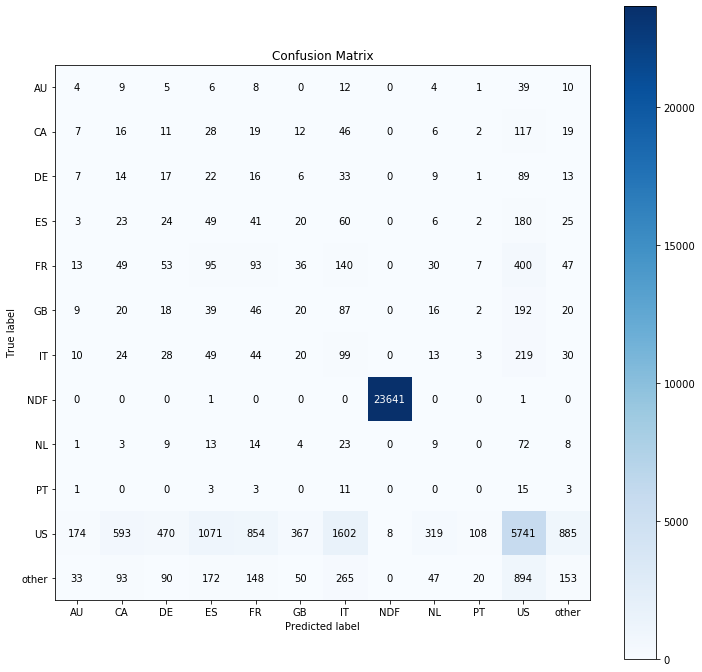

In [113]:
# Accuracy
acc_comb_nn = m.accuracy_score( y_test_comb_nn, yhat_comb_nn )
print(f'Accuracy: {acc_comb_nn}')

# Balanced Accuracy
balanced_acc_comb_nn = m.balanced_accuracy_score(y_test_comb_nn, yhat_comb_nn)
print(f'Balanced Accuracy: {balanced_acc_comb_nn}')

# Kappa Metrics
kappa_comb_nn = m.cohen_kappa_score(y_test_comb_nn, yhat_comb_nn)
print(f'Kappa Score: {kappa_comb_nn}')

# Classification report
print(m.classification_report(y_test_comb_nn, yhat_comb_nn))

# Confusion Matrix
mt.plot_confusion_matrix( y_test_comb_nn, yhat_comb_nn, normalize=False, figsize=(12,12));

# Performance
comb_performance = {'model': 'NN Model - SMOTE + TOMEKLINK', 
                    'acc': np.round(acc_comb_nn, 6), 
                    'balanced_acc': np.round(balanced_acc_comb_nn, 6), 
                    'kappa_score': np.round(kappa_comb_nn, 6)}

#### 7.2.4.2. SMOTE + TOMEKLINK - Cross-Validation

In [114]:
# cross validation performance
acc_comb, balanced_acc_comb, kappa_comb = cross_validation(num_fold = 5, 
                                                           x_train = x_train, 
                                                           y_train = y_train, 
                                                           model = model_comb, 
                                                           response_encoder = ohe, 
                                                           balance_model = combine, 
                                                           verbose = True)

Fold Number:1/5
Fold Number:2/5
Fold Number:3/5
Fold Number:4/5
Fold Number:5/5


In [115]:
# Performance
comb_performance_cv = {'model': 'NN Model - SMOTE + TOMEKLINK - CV',
                       'acc': f'{np.round(np.mean(acc_over), 2)} +/- {np.round(np.std(acc_over), 4)}',
                       'balanced_acc': f'{np.round(np.mean(balanced_acc_over), 2)} +/- {np.round(np.std(balanced_acc_over), 4)}',
                       'kappa_score': f'{np.round(np.mean(kappa_over), 2)} +/- {np.round(np.std(kappa_over), 4)}'}

In [116]:
print(f'Avg Accuracy: {np.round(np.mean(acc_comb), 2)} +/- {np.round(np.std(acc_comb),5)}')
print(f'Avg Balanced Accuracy: {np.round(np.mean(balanced_acc_comb), 2)} +/- {np.round(np.std(balanced_acc_comb),5)}')
print(f'Avg Kappa Score: {np.round(np.mean(kappa_comb), 2)} +/- {np.round(np.std(kappa_comb), 4)}')

Avg Accuracy: 0.75 +/- 0.03393
Avg Balanced Accuracy: 0.19 +/- 0.00469
Avg Kappa Score: 0.58 +/- 0.0476


# 8.0. Hyper Parameter Tuning

Hyper Parameter Tuning will not be considered until the most optimal machine learning model is selected, at this first cycle was considered only one model to complete the cycle and go through for all the major phases to validate the feasibility of the project.

# 9.0. Error Translation and Interpretation

# 10.0. Deploy Model

No models will be deployed yet.

# 11.0. Conclusion

Data preparation provided an increase in Balanced Accuracy of 30% for the oversampling mechanisms, but a decrease of 28% for Overall Accuracy and 45% for Kappa Score.

The improvement was expected due to the functioning of the Neural Network, which is very sensitive to the lack of scale between attributes.

After this phase the discrepancy between the mechanisms became evident, with a better performance for oversampling mechanisms, with a small advantage for SMOTE Tomek Link.

A disadvantage was an increase in processing time due to the SMOTE Tomek Link balancing mechanism with the new dataset.

## 11.1. Current Cycle Performance

In [123]:
# performance dataframe
df_performance = pd.DataFrame([baseline_performance, imb_performance, imb_performance_cv, 
                               under_performance, under_performance_cv, 
                               over_performance, over_performance_cv, 
                               comb_performance, comb_performance_cv])

df_performance['cycle'] = '7th_cycle'
df_performance['process'] = 'data_preparation'
df_performance = df_performance[['cycle', 'process', 'model', 'acc', 'balanced_acc', 'kappa_score']]

# save 7th cycle to comparison
df_performance.to_csv('../Datasets/7th_cycle_performance', index=False)

# display performance dataframe
df_performance

,cycle,process,model,acc,balanced_acc,kappa_score
0,7th_cycle,data_preparation,Baseline Model,0.424861,0.082064,NaN
1,7th_cycle,data_preparation,NN Model - Imbalanced Data,0.873012,0.166749,0.765641
2,7th_cycle,data_preparation,NN Model - Imbalanced Data - CV,0.87 +/- 0.0003,0.17 +/- 0.0005,0.77 +/- 0.0005
3,7th_cycle,data_preparation,NN Model - Random Undersampling,0.61555,0.177559,0.409757
4,7th_cycle,data_preparation,NN Model - Random Undersampling - CV,0.63 +/- 0.0039,0.21 +/- 0.0138,0.42 +/- 0.0046
5,7th_cycle,data_preparation,NN Model - Random Oversampling,0.597527,0.173067,0.3895
6,7th_cycle,data_preparation,NN Model - Random Oversampling - CV,0.63 +/- 0.0098,0.22 +/- 0.0116,0.42 +/- 0.0117
7,7th_cycle,data_preparation,NN Model - SMOTE + TOMEKLINK,0.727783,0.184554,0.550771
8,7th_cycle,data_preparation,NN Model - SMOTE + TOMEKLINK - CV,0.63 +/- 0.0098,0.22 +/- 0.0116,0.42 +/- 0.0117


## 11.2. Cycle Comparison

In [128]:
# first cycle performance load
performance_1st_cycle = pd.read_csv('../Datasets/1st_cycle_performance')

# second cycle performance load
performance_2nd_cycle = pd.read_csv('../Datasets/2nd_cycle_performance')

# third cycle performance laod
performance_3rd_cycle = pd.read_csv('../Datasets/3rd_cycle_performance')

# fourth cycle performance load
performance_4th_cycle = pd.read_csv('../Datasets/4th_cycle_performance')

# fifth cycle performance load
performance_5th_cycle = pd.read_csv('../Datasets/5th_cycle_performance')

# sixth cycle performance load
performance_6th_cycle = pd.read_csv('../Datasets/6th_cycle_performance')

# join cycles dataframes
performance = pd.concat([performance_1st_cycle, 
                         performance_2nd_cycle, 
                         performance_3rd_cycle[performance_3rd_cycle['model'] == 'Neural Network Model - CV'], 
                         performance_4th_cycle[performance_4th_cycle['model'] == 'Neural Network Model - CV'], 
                         performance_5th_cycle[performance_5th_cycle['model'] == 'NN Model - Imbalanced Data - CV'], 
                         performance_6th_cycle[performance_6th_cycle['model'] == 'NN Model - Imbalanced Data - CV'], 
                         df_performance[df_performance['model'] == 'NN Model - SMOTE + TOMEKLINK - CV']])\
                        .reset_index(drop=True)

# select the models desired
performance = performance[performance['model'] != 'Baseline Model'].fillna(0)

# display performance
performance

,cycle,process,model,acc,balanced_acc,kappa_score
0,1st_cycle,validation_pipeline,Neural Network Model,0.70407,0,0
2,2nd_cycle,baseline_model,Neural Network Model,0.70275,0.091927,0.002145
3,3rd_cycle,replace_na,Neural Network Model - CV,0.63 +/- 0.0013,0.11 +/- 0.0009,0.24 +/- 0.0063
4,4th_cycle,feature_engineering,Neural Network Model - CV,0.87 +/- 0.0,0.17 +/- 0.0,0.77 +/- 0.0001
5,5th_cycle,balanced_dataset,NN Model - Imbalanced Data - CV,0.87 +/- 0.0001,0.17 +/- 0.0,0.77 +/- 0.0002
6,6th_cycle,exploratory_data_analysis,NN Model - Imbalanced Data - CV,0.87 +/- 0.0001,0.17 +/- 0.0,0.77 +/- 0.0002
7,7th_cycle,data_preparation,NN Model - SMOTE + TOMEKLINK - CV,0.63 +/- 0.0098,0.22 +/- 0.0116,0.42 +/- 0.0117


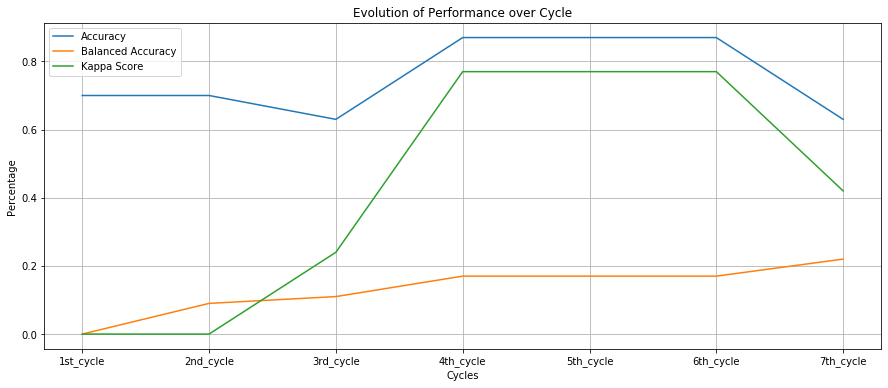

In [125]:
plt.figure(figsize=(15,6))

# formated metrics
performance['acc'] = performance['acc'].apply(lambda x: str(x)[0:4]).astype(float)

performance['balanced_acc'] = performance['balanced_acc'].apply(lambda x: str(x)[0:4]).astype(float)

performance['kappa_score'] = performance['kappa_score'].apply(lambda x: str(x)[0:4]).astype(float)

# Evolution of Performance over Cycles
sns.lineplot(x='cycle', y='acc', data=performance)

sns.lineplot(x='cycle', y='balanced_acc', data=performance)

sns.lineplot(x='cycle', y='kappa_score', data=performance)

# set legend and titles
plt.legend(labels=['Accuracy','Balanced Accuracy', 'Kappa Score'])
plt.title('Evolution of Performance over Cycle')
plt.ylabel('Percentage')
plt.xlabel('Cycles')
plt.grid();

In [126]:
performance['pct_acc'] = np.round(performance['acc'].pct_change(), 2)

performance['pct_bal_acc'] = np.round(performance['balanced_acc'].pct_change(), 2)

performance['pct_kappa_score'] = np.round(performance['kappa_score'].pct_change(), 2)

performance[['cycle', 'process', 'model', 'acc', 'pct_acc', 
             'balanced_acc', 'pct_bal_acc', 'kappa_score', 'pct_kappa_score']]

,cycle,process,model,acc,pct_acc,balanced_acc,pct_bal_acc,kappa_score,pct_kappa_score
0,1st_cycle,validation_pipeline,Neural Network Model,0.70,NaN,0.00,NaN,0.00,NaN
2,2nd_cycle,baseline_model,Neural Network Model,0.70,0.00,0.09,inf,0.00,NaN
3,3rd_cycle,replace_na,Neural Network Model - CV,0.63,-0.10,0.11,0.22,0.24,inf
4,4th_cycle,feature_engineering,Neural Network Model - CV,0.87,0.38,0.17,0.55,0.77,2.21
5,5th_cycle,balanced_dataset,NN Model - Imbalanced Data - CV,0.87,0.00,0.17,0.00,0.77,0.00
6,6th_cycle,exploratory_data_analysis,NN Model - Imbalanced Data - CV,0.87,0.00,0.17,0.00,0.77,0.00
7,7th_cycle,data_preparation,NN Model - SMOTE + TOMEKLINK - CV,0.63,-0.28,0.22,0.29,0.42,-0.45
